In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

import sys
from pathlib import Path

Path("./Paper Figures/").mkdir(parents=True, exist_ok=True)
Path("./Paper Data/").mkdir(parents=True, exist_ok=True)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [3]:
def Exact_NEIM(mu, f, U, max_modes=25):
    """
    Compute a non-neural network NEIM for solution
    independent nonlinearities.
    
    mu: parameters
    f:  nonlinearity corresponding to each mu in a matrix
    U:  POD basis
    """
    
    Pf = U.T @ f # projection of f
    
    selected_parameters = []
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    idx = np.argmax([np.linalg.norm(Pf[:, i])**2 for i in range(Pf.shape[1])])
    mu_1 = mu[idx]
    selected_parameters.append(mu_1)
    selected_indices.append(idx)
    
    NN_1 = np.copy(Pf[:, [idx]])
    NN_1 /= np.linalg.norm(NN_1)
    trained_networks.append(NN_1)
    thetas = np.array([np.dot(NN_1.reshape(-1), Pf[:, i])/np.linalg.norm(NN_1)**2 for i in range(Pf.shape[1])])
    current_approximation = thetas * NN_1
    
    # NEIM Update Step
    for i in range(1, max_modes):
        idx = np.argmax([np.linalg.norm(current_approximation[:, i] - Pf[:, i])**2 for i in range(Pf.shape[1])])
        mu_i = mu[idx]
        selected_parameters.append(mu_i)
        selected_indices.append(idx)
        
        # orthogonalize selected vector with respect to previous vectors
        NN_i = Pf[:, [idx]]
        for network in trained_networks:
            NN_i -= np.dot(NN_i.reshape(-1), network.reshape(-1)) * network / np.linalg.norm(network)**2
        NN_i /= np.linalg.norm(NN_i)
        
        trained_networks.append(NN_i)
        A = np.zeros((i+1, i+1))
        for j in range(A.shape[0]):
            for k in range(A.shape[1]):
                A[j, k] = np.dot(trained_networks[j].reshape(-1), trained_networks[k].reshape(-1))
        
        thetas = []
        for j in range(Pf.shape[1]):
            b = np.zeros((i+1, 1))
            for k in range(b.shape[0]):
                b[k, 0] = np.dot(trained_networks[k].reshape(-1), Pf[:, j])
            thetas.append(np.linalg.solve(A, b).reshape(-1))
        thetas = np.array(thetas).T
        current_approximation = np.array(trained_networks)[:, :, 0].T @ thetas
    
    trained_networks = np.array(trained_networks)[:, :, 0].T
    
    def Exact_NEIM_approximation(new_mu, num_modes=-1):
        if num_modes == -1:
            num_modes = trained_networks.shape[1]
        thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='cubic').reshape(-1, 1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='nearest').reshape(-1, 1)
        return U @ (trained_networks[:, :num_modes] @ thetas_[:num_modes])
    
    return Exact_NEIM_approximation, selected_indices

In [4]:
# Note that in the example, there is no actual input for
# the neural network. Instead, to simulate NEIM, we will
# choose a simple "solution".

def solution_fn(mu, f):
    # compute full order solutions
    sols = np.zeros((mu.shape[0], f.shape[0]), dtype=np.double)
    A = 2*np.eye(f.shape[0], dtype=np.double) - np.eye(f.shape[0], k=1, dtype=np.double) - np.eye(f.shape[0], k=-1, dtype=np.double)
    A = 30 * A
    A = A[1:-1, 1:-1]
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = np.zeros((f.shape[0], 1), dtype=np.double)
        sol[1:-1] = np.linalg.solve(A, f[1:-1, [i]])
        sol = sol.reshape(-1)
        sols[i] = sol
            
    return sols

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 1)
        self.fc3 = nn.Linear(1, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.zeros(NUM_PARAMS)
    for i in range(NUM_PARAMS):
        # compute error
        s = 0
        for j in range(NUM_PARAMS):
            s += np.sum(f_NEIM[i, j]**2)
        errors[i] = s / NUM_PARAMS
    
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])]), dtype=torch.double)
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = criterion(output, y_data)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        #scheduler.step()
        scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
            numerator += np.dot(f_NEIM[i, j], net_u_mu)
            denominator += np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        errors = np.zeros(NUM_PARAMS)
        for i in range(NUM_PARAMS):
            # compute error
            s = 0
            for j in range(NUM_PARAMS):
                s += np.sum((f_NEIM[i, j] - approx(ro_sols[j], i))**2)
            errors[i] = s / NUM_PARAMS
    
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2
        
        for j in range(f_NEIM.shape[1]):
            y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = criterion(output, y_data)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            #scheduler.step()
            scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS_numerator = np.zeros((num_nets, num_nets), dtype=np.double)
            LHS_denominator = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS_numerator = np.zeros((num_nets, 1), dtype=np.double)
            RHS_denominator = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]

                for k1 in range(num_nets):
                    RHS_numerator[k1] += np.dot(f_NEIM[i, j], nets_u_mu[k1])
                    RHS_denominator[k1] += np.dot(nets_u_mu[k1], nets_u_mu[k1])
                    for k2 in range(num_nets):
                        LHS_numerator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k2])
                        LHS_denominator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k1])

            LHS = LHS_numerator / LHS_denominator
            RHS = RHS_numerator / RHS_denominator
            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return (V @ s.reshape(-1, 1)).reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathcal{D}\to\mathbb{R}$ defined by $$s(x;\mu) = (1-x)\cos(3\pi\mu(x+1))e^{-(1+x)\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{D} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equidistantly spaced points in $\Omega$ for $i=1,\dots,n$, $n=100$. Define $f:\mathcal{D}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1;\mu),\dots,s(x_n;\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{D}$. 

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

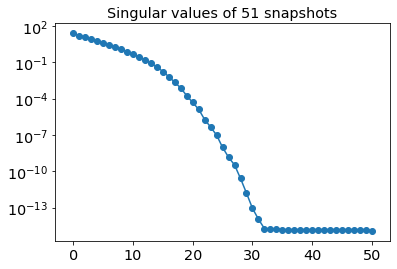

In [5]:
def s(x, mu):
    return (1-x)*np.cos(3*np.pi*mu*(x+1))*np.exp(-(1+x)*mu)

x = np.linspace(-1, 1, 100).reshape(-1,1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
f = s(x, mu) # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

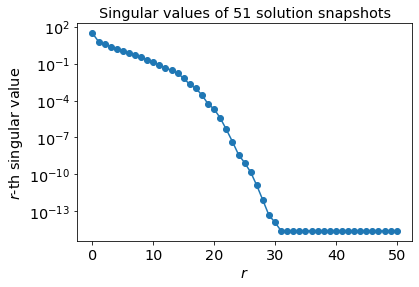

(100, 51)


In [6]:
RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.semilogy(np.arange(sing_vals.shape[0]), sing_vals)
plt.title("Singular values of 51 solution snapshots")
plt.xlabel("$r$")
plt.ylabel("$r$-th singular value")
plt.savefig(f'./Paper Figures/singular_values_experiment_1.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/singular_values_experiment_1_x.npy", 'wb') as file_obj:
    np.save(file_obj, np.arange(sing_vals.shape[0]))
with open(f"./Paper Data/singular_values_experiment_1_y.npy", 'wb') as file_obj:
    np.save(file_obj, sing_vals)
plt.show()
print(V.shape)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

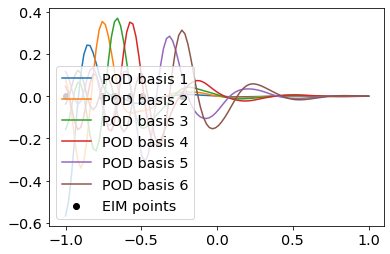

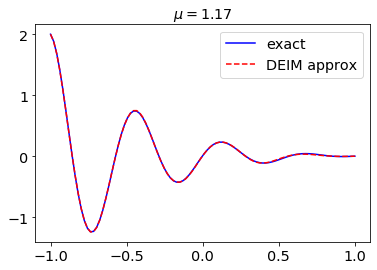

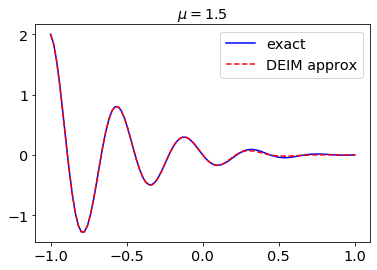

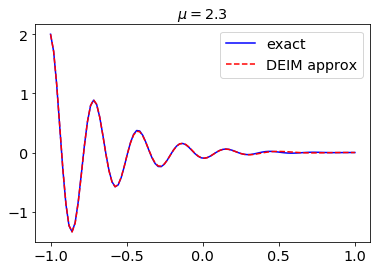

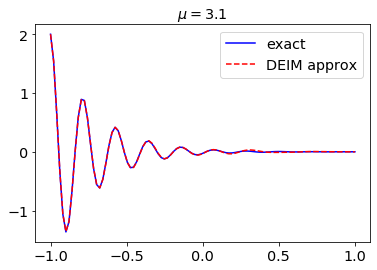

In [7]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    exact = s(x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for POD, DEIM, Exact NEIM
Exact NEIM is the version of NEIM for nonlinearities which do not depend on solutions (they depend on space and parameters). In this case, NEIM should approximate constant vectors in its expansion, so we can instead use these exact vectors.

**If you want better results for Exact NEIM, increase NUM_TRAIN_PARAMS**

[0, 13, 30, 50, 6]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.4605560699494373
100 0.2355146094415539
200 0.14574454546004537
300 0.0942656204150051
400 0.060531103018118565
500 0.039602696590501536
600 0.026661564962254337
700 0.018307607880463872
800 0.012634253921870746
900 0.008642553604240802
1000 0.005794781040592728
1100 0.003774983336746875
1200 0.0023728511284517
1300 0.0014312659657618075
1400 0.0008248907718848247
1500 0.0004527692956210696
1600 0.00023610898244049057
1700 0.00011676995279425505
1800 5.4692698926150426e-05
1900 2.4230690794534503e-05
2000 1.0140765385012808e-05
2100 4.002948717479869e-06
2200 1.4876244956855052e-06
2300 5.193413959309156e-07
2400 1.6987845853183687e-07
2500 5.1912699058709915e-08
2600 1.4772626418975122e-08
2700 3.901852875687326e-09
2800 9.543669264297382e-10
2900 2.1688581155319301e-10
3000 4.723694494844837e-11
3100 1.1426536151750015e-11
3200 4.43950944015905e-12
3300 3.1134798688322628e-12
3400 2.811176952455651e

9200 1.4087414259896224e-12
9300 1.4025337036210233e-12
9400 1.3964408912267633e-12
9500 1.3904606304338016e-12
9600 1.3845906099805987e-12
9700 1.3788285647423112e-12
9800 1.3731722751476443e-12
9900 1.3676195661737275e-12
10000 1.362168306631994e-12
10100 1.3568164084311822e-12
10200 1.351561825751844e-12
10300 1.3464025541267114e-12
10400 1.3413366299663963e-12
10500 1.3363621295433127e-12
10600 1.3314771683363863e-12
10700 1.3266799002843079e-12
10800 1.3219685170635825e-12
10900 1.3173412473151574e-12
11000 1.31306816079517e-12
11100 1.3088289325523512e-12
11200 1.3050948477628727e-12
11300 1.3015836569791075e-12
11400 1.2984706782377348e-12
11500 1.2951521169907112e-12
11600 1.2924070648329178e-12
11700 1.2894766995456636e-12
11800 1.2944755053255439e-12
11900 1.2844511621950364e-12
12000 1.2837965863663888e-12
12100 1.2801331090249703e-12
12200 1.2782636469946815e-12
12300 1.276409857131475e-12
12400 1.2745714275612142e-12
12500 1.272913672060471e-12
12600 1.2713651836171457e-12

18200 8.983920976175443e-12
18300 8.98391717007422e-12
18400 8.983913363832095e-12
18500 8.983909557552777e-12
18600 8.983905751130892e-12
18700 8.983901944638572e-12
18800 8.983898137988432e-12
18900 8.983894331223152e-12
19000 8.983890524370364e-12
19100 8.983886717369716e-12
19200 8.983882910231883e-12
19300 8.983879102960099e-12
19400 8.98387529553443e-12
19500 8.983871487961754e-12
19600 8.983867680226714e-12
19700 8.98386387226828e-12
19800 8.983860064244197e-12
19900 8.983856255920223e-12

Finding theta...
50 Max Error: 10.256539689757638 Mean Error: 4.851367999500746
0 0.2868001318203933
100 0.19504675973058153
200 0.1246410687577045
300 0.07572873226809206
400 0.04429382058903374
500 0.024905320606780693
600 0.013409065517723527
700 0.006904431221387941
800 0.0034152620410554295
900 0.0016325141183565091
1000 0.0007556791551012549
1100 0.00033776537634144164
1200 0.00014492561268243607
1300 5.9300377124094395e-05
1400 2.299614782293787e-05
1500 8.40474052998527e-06
1600 2.8805

7200 9.13911814776534e-07
7300 8.667258165505577e-07
7400 8.218789987042956e-07
7500 7.819131056219207e-07
7600 7.395194668876908e-07
7700 7.01815034638797e-07
7800 6.657621906633055e-07
7900 6.317845586539647e-07
8000 6.010664746246462e-07
8100 5.691595812479966e-07
8200 5.402765214828988e-07
8300 5.129218738219065e-07
8400 4.869945006239552e-07
8500 4.6242674649925323e-07
8600 4.3988098062876976e-07
8700 4.170283317969138e-07
8800 3.9607766906046e-07
8900 3.7620801219347333e-07
9000 3.5735947764828305e-07
9100 3.3947650860354147e-07
9200 3.225096825986453e-07
9300 3.0692311019862674e-07
9400 2.911374082539023e-07
9500 2.766280201266227e-07
9600 2.628623008088544e-07
9700 2.4997165695981356e-07
9800 2.3837875334453025e-07
9900 2.2764202561660225e-07
10000 2.1735068584087853e-07
10100 2.07489602532297e-07
10200 1.9804401923033606e-07
10300 1.9060845658835543e-07
10400 1.8124087449789496e-07
10500 1.7368532323787252e-07
10600 1.6639567155881138e-07
10700 1.59347931222755e-07
10800 1.525

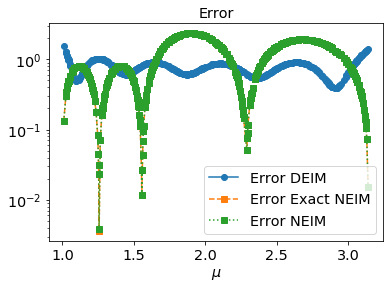

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.3742892596664328
100 0.22442247468688598
200 0.15410203922457458
300 0.10845794160525447
400 0.07545076560930451
500 0.05125470131649919
600 0.03387220678572408
700 0.021675172129762763
800 0.013363244200816537
900 0.007907963353641549
1000 0.004484700671688557
1100 0.002438745687688601
1200 0.0012735785144812057
1300 0.000639350825157969
1400 0.00030845013349599626
1500 0.00014280309930198953
1600 6.330713239518963e-05
1700 2.680477528587718e-05
1800 1.080918077127067e-05
1900 4.138866661674324e-06
2000 1.4999366191748613e-06
2100 5.127070369837578e-07
2200 1.6470154523888685e-07
2300 4.9543426061402655e-08
2400 1.3914256657515455e-08
2500 3.6507262974080328e-09
2600 9.097225393376358e-10
2700 2.337181490197383e-10
2800 7.997307815072549e-11
2900 4.735551569036045e-11
3000 4.0402909559993355e-11
3100 3.842460882067271e-11
3200 3.735379744453103e-11
3300 3.646545620743599e-11
3400 3

9400 2.3228168473615692e-07
9500 2.2038927454404938e-07
9600 2.0911752612105759e-07
9700 1.9843306402215426e-07
9800 1.8830440143652162e-07
9900 1.7870182418441827e-07
10000 1.6959728269708098e-07
10100 1.609642913544256e-07
10200 1.5277783461075202e-07
10300 1.4994645552612689e-07
10400 1.3765162499061346e-07
10500 1.3066816135275501e-07
10600 1.240442878030865e-07
10700 1.1776102508375133e-07
10800 1.1180052971995033e-07
10900 1.0614794853755841e-07
11000 1.0078148577860353e-07
11100 9.5691721353343e-08
11200 9.086243954964532e-08
11300 8.628011285502962e-08
11400 8.193269701124364e-08
11500 7.780588777877716e-08
11600 7.389026279787628e-08
11700 7.017424131625777e-08
11800 6.675903694696368e-08
11900 6.368407628138747e-08
12000 6.077822743736954e-08
12100 5.830108262007498e-08
12200 5.532917147330592e-08
12300 5.2777273080469435e-08
12400 5.043371611674429e-08
12500 4.8311862535502413e-08
12600 4.6267573712225993e-08
12700 4.42963863593454e-08
12800 4.291851281040733e-08
12900 4.072

18700 4.3407355719237407e-10
18800 4.3407352220555623e-10
18900 4.340734872180032e-10
19000 4.340734522289139e-10
19100 4.3407341723782475e-10
19200 4.3407338224419673e-10
19300 4.3407334724759447e-10
19400 4.340733122476979e-10
19500 4.3407327724419564e-10
19600 4.340732422368912e-10
19700 4.340732072254185e-10
19800 4.340731722095618e-10
19900 4.3407313718910737e-10

Finding theta...
50 Max Error: 10.256539885328653 Mean Error: 4.85136892078978
0 0.6130876628835732
100 0.4209510226750469
200 0.3161533362543165
300 0.2350130126424429
400 0.16876164728469284
500 0.1152980984684186
600 0.07483664841704511
700 0.04621300790870538
800 0.027094710077109858
900 0.01501203313374147
1000 0.007821601979509023
1100 0.003820507158255182
1200 0.001749376882274523
1300 0.000752758675229019
1400 0.0003054406250223492
1500 0.00011718833726741434
1600 4.25579493408646e-05
1700 1.4615998790069483e-05
1800 4.7350653133154415e-06
1900 1.441720737642678e-06
2000 4.108390321157448e-07
2100 1.0915317797293

8000 3.558172025912597e-09
8100 3.5581717076090492e-09
8200 3.558171388613236e-09
8300 3.558171068971213e-09
8400 3.558170748726925e-09
8500 3.5581704279223907e-09
8600 3.5581701065969515e-09
8700 3.5581697847880785e-09
8800 3.5581694625313815e-09
8900 3.558169139860312e-09
9000 3.558168816806174e-09
9100 3.558168493398726e-09
9200 3.558168169665072e-09
9300 3.5581678456314053e-09
9400 3.558167521321802e-09
9500 3.5581671967586463e-09
9600 3.558166871962785e-09
9700 3.558166546953305e-09
9800 3.5581662217483385e-09
9900 3.558165896364151e-09
10000 3.5581655708161194e-09
10100 3.558165245118586e-09
10200 3.5581649192842535e-09
10300 3.5581645933244815e-09
10400 3.5581642672510615e-09
10500 3.558163941073699e-09
10600 3.558163614801523e-09
10700 3.558163288442826e-09
10800 3.5581629620055337e-09
10900 3.558162635496177e-09
11000 3.558162308921693e-09
11100 3.5581619822877927e-09
11200 3.558161655599539e-09
11300 3.5581613288621374e-09
11400 3.5581610020796768e-09
11500 3.558160675256394e

17200 5.25283736836283e-09
17300 5.25283682582121e-09
17400 5.2528362832621085e-09
17500 5.252835740683938e-09
17600 5.25283519808543e-09
17700 5.252834655464789e-09
17800 5.2528341128204665e-09
17900 5.252833570150599e-09
18000 5.252833027453493e-09
18100 5.2528324847272055e-09
18200 5.252831941969678e-09
18300 5.252831399178896e-09
18400 5.25283085635263e-09
18500 5.252830313488603e-09
18600 5.252829770584627e-09
18700 5.252829227637859e-09
18800 5.252828684646041e-09
18900 5.252828141606381e-09
19000 5.252827598516003e-09
19100 5.252827055371815e-09
19200 5.2528265121710785e-09
19300 5.252825968910096e-09
19400 5.252825425585688e-09
19500 5.2528248821942205e-09
19600 5.2528243387320715e-09
19700 5.252823795195259e-09
19800 5.252823251579705e-09
19900 5.2528227078811375e-09

Finding theta...
39 Max Error: 3.3835396095552976 Mean Error: 0.9280968052482947
0 0.46617127892861665
100 0.26445788398907744
200 0.14706564798328634
300 0.0763864664089251
400 0.0385191919377978
500 0.018588725

6300 1.2161638451277256e-08
6400 1.2161637756954732e-08
6500 1.2161637046687028e-08
6600 1.2161636319762223e-08
6700 1.2161635575431169e-08
6800 1.2161634812905862e-08
6900 1.2161634031358515e-08
7000 1.216163322991947e-08
7100 1.2161632407676322e-08
7200 1.21616315636719e-08
7300 1.216163069690344e-08
7400 1.2161629806320607e-08
7500 1.2161628890823337e-08
7600 1.2161627949261104e-08
7700 1.2161626980431627e-08
7800 1.216162598307783e-08
7900 1.2161624955887673e-08
8000 1.2161623897491458e-08
8100 1.2161622806461648e-08
8200 1.216162168130939e-08
8300 1.216162052048451e-08
8400 1.2161619322373839e-08
8500 1.2161618085299719e-08
8600 1.216161680751769e-08
8700 1.2161615487217232e-08
8800 1.2161614122519856e-08
8900 1.216161271147714e-08
9000 1.2161611252071857e-08
9100 1.216160974221658e-08
9200 1.2161608179753404e-08
9300 1.2161606562453726e-08
9400 1.2161604888019708e-08
9500 1.2161603154083895e-08
9600 1.2161601358211148e-08
9700 1.2161599497899121e-08
9800 1.2161597570582148e-08
99

15500 3.5531807790787403e-08
15600 3.553177509075411e-08
15700 3.553174395340406e-08
15800 3.5531714418135285e-08
15900 3.553168651144224e-08
16000 3.5531660246564966e-08
16100 3.553163562338299e-08
16200 3.5531612628566605e-08
16300 3.5531591235995855e-08
16400 3.5531571407441266e-08
16500 3.553155309350033e-08
16600 3.553153623476715e-08
16700 3.5531520763201954e-08
16800 3.553150660366742e-08
16900 3.553149367557627e-08
17000 3.553148189460348e-08
17100 3.553147117440169e-08
17200 3.553146142826416e-08
17300 3.553145257067874e-08
17400 3.553144451872299e-08
17500 3.553143719325819e-08
17600 3.553143051989312e-08
17700 3.5531424429697636e-08
17800 3.5531418859660875e-08
17900 3.553141375290363e-08
18000 3.553140905866644e-08
18100 3.55314047321022e-08
18200 3.5531400733911304e-08
18300 3.553139702986491e-08
18400 3.5531393590255245e-08
18500 3.553139038931672e-08
18600 3.5531387404649897e-08
18700 3.55313846166808e-08
18800 3.553138200817169e-08
18900 3.5531379563799616e-08
19000 3.5

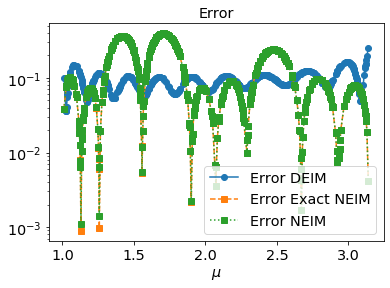

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.4858901674489733
100 0.2607242616948034
200 0.17963068250735786
300 0.12326205816995489
400 0.07658908721301926
500 0.041418655632985246
600 0.01957919653172191
700 0.008404256474914594
800 0.003399653494935709
900 0.0013206056569793556
1000 0.000495426091446509
1100 0.00017950697279841887
1200 6.26278369560921e-05
1300 2.0925736007767055e-05
1400 6.64991910085144e-06
1500 1.9949352085051556e-06
1600 5.607741290477046e-07
1700 1.4666233068034173e-07
1800 3.546821973644742e-08
1900 7.909451311599183e-09
2000 1.6481752853944727e-09
2100 3.509979921475962e-10
2200 1.054255670646391e-10
2300 6.116935817945131e-11
2400 5.1763287498522654e-11
2500 4.801691504754782e-11
2600 4.533900467031152e-11
2700 4.3051588515731035e-11
2800 4.103155973063088e-11
2900 3.923092193603912e-11
3000 3.76159465422841e-11
3100 3.6159493857855177e-11
3200 3.4839322529457646e-11
3300 3.3637127

9000 7.83905436945935e-12
9100 7.811238667001009e-12
9200 7.792832973174011e-12
9300 7.774532207117994e-12
9400 7.761203115483264e-12
9500 7.741317759910944e-12
9600 7.726718388760201e-12
9700 7.712182939623402e-12
9800 7.69771038716122e-12
9900 7.685004445557867e-12
10000 7.673364000383945e-12
10100 7.661770294627905e-12
10200 7.650215659845124e-12
10300 7.639687411211765e-12
10400 7.630382760515243e-12
10500 7.62110515367731e-12
10600 7.611852094491526e-12
10700 7.603784654279198e-12
10800 7.598245409581269e-12
10900 7.595913709432421e-12
11000 7.594897667852234e-12
11100 7.594465933128045e-12
11200 7.59429262710803e-12
11300 7.594226093467152e-12
11400 7.594200552229991e-12
11500 7.594190748090509e-12
11600 7.59418684587511e-12
11700 7.594183784290176e-12
11800 7.594180722682652e-12
11900 7.594177661036049e-12
12000 7.594174599398673e-12
12100 7.594171537702912e-12
12200 7.594168476017524e-12
12300 7.59416541431791e-12
12400 7.594162352519865e-12
12500 7.594159290785983e-12
12600 7.

18600 4.8046261103641745e-12
18700 4.804625077208144e-12
18800 4.804624043926512e-12
18900 4.804623010472427e-12
19000 4.804621976867679e-12
19100 4.804620943085039e-12
19200 4.8046199091164e-12
19300 4.8046188749898456e-12
19400 4.80461784064813e-12
19500 4.804616806103812e-12
19600 4.804615771340726e-12
19700 4.804614736364726e-12
19800 4.804613701149179e-12
19900 4.804612665703498e-12

Finding theta...
50 Max Error: 10.256539689631413 Mean Error: 4.851368000512729
0 0.2803267695207126
100 0.18528268808623904
200 0.11315071949096742
300 0.06395212867153911
400 0.033950153361051026
500 0.01728608432246665
600 0.008602020368450697
700 0.004249542747238092
800 0.0020884428718865107
900 0.0010096246087726503
1000 0.0004728531039293615
1100 0.00021177087480625105
1200 8.983959330143976e-05
1300 3.5861159000546786e-05
1400 1.3402186401834267e-05
1500 4.67042458223461e-06
1600 1.5120691143686822e-06
1700 4.531944772760862e-07
1800 1.2532734472362657e-07
1900 3.190926410418046e-08
2000 7.508

7700 2.8186646506273113e-11
7800 2.811114461428186e-11
7900 2.8036642688547127e-11
8000 2.796309608975007e-11
8100 2.789046410145879e-11
8200 2.7818709555221597e-11
8300 2.7747798490573356e-11
8400 2.7677699847645027e-11
8500 2.760838518873921e-11
8600 2.7539828446862577e-11
8700 2.747200569748001e-11
8800 2.74341469307717e-11
8900 2.7359321552723877e-11
9000 2.731117706777361e-11
9100 2.7263387551554913e-11
9200 2.721594471386507e-11
9300 2.7168842463542776e-11
9400 2.712269611419262e-11
9500 2.7085020842070162e-11
9600 2.7051319257199296e-11
9700 2.7017795991997847e-11
9800 2.698444143236737e-11
9900 2.6951253810993603e-11
10000 2.6918231421419563e-11
10100 2.6889674649279886e-11
10200 2.6871566700387815e-11
10300 2.6863500564130366e-11
10400 2.6859990654346916e-11
10500 2.6858496333934638e-11
10600 2.6857897801979504e-11
10700 2.685766808308141e-11
10800 2.6857579920376344e-11
10900 2.685754608743121e-11
11000 2.6857533104933682e-11
11100 2.685752704504381e-11
11200 2.68575212690819

16800 1.9097030308762352e-11
16900 1.9097026092279147e-11
17000 1.909702187484093e-11
17100 1.9097017656372793e-11
17200 1.9097013436906022e-11
17300 1.9097009216264106e-11
17400 1.9097004994464136e-11
17500 1.9097000771442654e-11
17600 1.9096996547198882e-11
17700 1.9096992321505603e-11
17800 1.9096988094504484e-11
17900 1.9096983865972618e-11
18000 1.9096979635968752e-11
18100 1.909697540432535e-11
18200 1.9096971170956115e-11
18300 1.9096966935855828e-11
18400 1.9096962698940212e-11
18500 1.9096958460064944e-11
18600 1.9096954219259828e-11
18700 1.90969499762135e-11
18800 1.9096945731041037e-11
18900 1.9096941483584535e-11
19000 1.9096937233768986e-11
19100 1.909693298138465e-11
19200 1.9096928726428028e-11
19300 1.9096924468786445e-11
19400 1.909692020834369e-11
19500 1.9096915944922432e-11
19600 1.9096911678467085e-11
19700 1.909690740879741e-11
19800 1.9096903135821806e-11
19900 1.9096898859422872e-11

Finding theta...
39 Max Error: 3.383539638628352 Mean Error: 0.928095909741669

5800 3.8302534046074735e-10
5900 3.830253102133929e-10
6000 3.830252799568331e-10
6100 3.8302524969173233e-10
6200 3.8302521941871627e-10
6300 3.8302518913831515e-10
6400 3.830251588510978e-10
6500 3.830251285576831e-10
6600 3.830250982583992e-10
6700 3.830250679537941e-10
6800 3.830250376442303e-10
6900 3.830250073301502e-10
7000 3.830249770118853e-10
7100 3.8302494668982116e-10
7200 3.8302491636418493e-10
7300 3.8302488603540455e-10
7400 3.8302485570360924e-10
7500 3.8302482536920046e-10
7600 3.830247950322818e-10
7700 3.830247646931158e-10
7800 3.830247343519844e-10
7900 3.8302470400891066e-10
8000 3.830246736642357e-10
8100 3.830246433180143e-10
8200 3.830246129704283e-10
8300 3.830245826215747e-10
8400 3.830245522716157e-10
8500 3.8302452192069695e-10
8600 3.8302449156880354e-10
8700 3.8302446121615165e-10
8800 3.830244308628054e-10
8900 3.830244005087902e-10
9000 3.830243701542552e-10
9100 3.8302433979923503e-10
9200 3.83024309443691e-10
9300 3.830242790878507e-10
9400 3.83024248

15000 1.9707831070145645e-10
15100 1.9707829447100059e-10
15200 1.9707827823963015e-10
15300 1.9707826200733613e-10
15400 1.9707824577393884e-10
15500 1.9707822953969935e-10
15600 1.9707821330425034e-10
15700 1.9707819706760562e-10
15800 1.970781808298297e-10
15900 1.9707816459084274e-10
16000 1.970781483504455e-10
16100 1.9707813210881787e-10
16200 1.970781158656805e-10
16300 1.970780996210617e-10
16400 1.9707808337489903e-10
16500 1.970780671271433e-10
16600 1.9707805087759327e-10
16700 1.9707803462641465e-10
16800 1.9707801837330373e-10
16900 1.9707800211830208e-10
17000 1.9707798586128416e-10
17100 1.9707796960217078e-10
17200 1.9707795334091304e-10
17300 1.9707793707729395e-10
17400 1.9707792081146567e-10
17500 1.970779045430814e-10
17600 1.9707788827221896e-10
17700 1.9707787199875935e-10
17800 1.9707785572247205e-10
17900 1.9707783944335155e-10
18000 1.9707782316125914e-10
18100 1.9707780687605555e-10
18200 1.9707779058770612e-10
18300 1.970777742960703e-10
18400 1.9707775800088

4000 7.867264583008654e-10
4100 7.867264138085925e-10
4200 7.867263691885089e-10
4300 7.867263244354614e-10
4400 7.867262795435621e-10
4500 7.86726234506945e-10
4600 7.867261893189534e-10
4700 7.867261439730584e-10
4800 7.867260984616867e-10
4900 7.867260527775554e-10
5000 7.867260069124671e-10
5100 7.867259608580301e-10
5200 7.867259146051491e-10
5300 7.867258681446872e-10
5400 7.867258214665819e-10
5500 7.867257745604862e-10
5600 7.867257274151148e-10
5700 7.867256800192971e-10
5800 7.867256323607835e-10
5900 7.86725584426913e-10
6000 7.867255362044103e-10
6100 7.867254876788916e-10
6200 7.867254388362042e-10
6300 7.867253896606759e-10
6400 7.867253401361869e-10
6500 7.867252902458522e-10
6600 7.867252399719984e-10
6700 7.867251892959554e-10
6800 7.867251381985954e-10
6900 7.867250866595222e-10
7000 7.867250346574436e-10
7100 7.867249821701866e-10
7200 7.867249291747271e-10
7300 7.86724875646645e-10
7400 7.867248215607108e-10
7500 7.86724766890704e-10
7600 7.867247116088037e-10
7700 

13900 8.636989096807074e-10
14000 8.636987400635487e-10
14100 8.636985692707254e-10
14200 8.636983975346507e-10
14300 8.636982251061149e-10
14400 8.636980522536816e-10
14500 8.636978792627112e-10
14600 8.636977064344357e-10
14700 8.636975340841597e-10
14800 8.636973625396992e-10
14900 8.636971921387327e-10
15000 8.636970232266951e-10
15100 8.63696856153411e-10
15200 8.636966912701229e-10
15300 8.63696528925674e-10
15400 8.636963694627354e-10
15500 8.636962132135544e-10
15600 8.636960604958053e-10
15700 8.636959116078482e-10
15800 8.636957668246182e-10
15900 8.636956263932848e-10
16000 8.636954905288931e-10
16100 8.63695359410662e-10
16200 8.636952331786748e-10
16300 8.636951119309238e-10
16400 8.636949957214731e-10
16500 8.636948845587688e-10
16600 8.63694778405564e-10
16700 8.636946771792448e-10
16800 8.636945807533331e-10
16900 8.636944889601398e-10
17000 8.636944015943587e-10
17100 8.636943184171394e-10
17200 8.636942391615376e-10
17300 8.636941635383286e-10
17400 8.636940912422061e

3200 2.1495244244874088e-08
3300 2.1495238763908652e-08
3400 2.1495236605207116e-08
3500 2.1495235753716833e-08
3600 2.1495235400426435e-08
3700 2.1495235104324767e-08
3800 2.149523479932232e-08
3900 2.1495234485016687e-08
4000 2.1495234160983876e-08
4100 2.149523382677591e-08
4200 2.1495233481920543e-08
4300 2.1495233125920695e-08
4400 2.1495232758251963e-08
4500 2.1495232378363268e-08
4600 2.149523198567317e-08
4700 2.149523157957116e-08
4800 2.1495231159415024e-08
4900 2.1495230724529347e-08
5000 2.1495230274203883e-08
5100 2.1495229807693496e-08
5200 2.1495229324214075e-08
5300 2.1495228822943457e-08
5400 2.14952283030176e-08
5500 2.1495227763530465e-08
5600 2.1495227203530987e-08
5700 2.1495226622021154e-08
5800 2.149522601795556e-08
5900 2.149522539023657e-08
6000 2.1495224737715084e-08
6100 2.1495224059186692e-08
6200 2.1495223353389114e-08
6300 2.1495222619001318e-08
6400 2.149522185463968e-08
6500 2.1495221058856543e-08
6600 2.1495220230136756e-08
6700 2.1495219366896085e-08
6

12300 1.524069847208984e-07
12400 1.5240684356198946e-07
12500 1.524066980398944e-07
12600 1.5240654817020327e-07
12700 1.524063939857809e-07
12800 1.524062355382685e-07
12900 1.5240607289959612e-07
13000 1.524059061634998e-07
13100 1.5240573544701329e-07
13200 1.5240556089191647e-07
13300 1.5240538266612064e-07
13400 1.524052009649502e-07
13500 1.5240501601230167e-07
13600 1.524048280616351e-07
13700 1.524046373967656e-07
13800 1.5240444433241346e-07
13900 1.5240424921446927e-07
14000 1.524040524199302e-07
14100 1.524038543564619e-07
14200 1.5240365546154376e-07
14300 1.5240345620114947e-07
14400 1.5240325706792728e-07
14500 1.5240305857884002e-07
14600 1.5240286127223675e-07
14700 1.5240266570433396e-07
14800 1.5240247244509764e-07
14900 1.5240228207352427e-07
15000 1.5240209517234123e-07
15100 1.5240191232215804e-07
15200 1.5240173409512707e-07
15300 1.5240156104818073e-07
15400 1.5240139371594966e-07
15500 1.5240123260347546e-07
15600 1.5240107817886285e-07
15700 1.5240093086603274

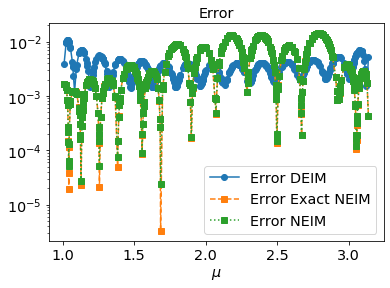

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 18, 49, 4]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.4046458444192575
100 0.24239152953737755
200 0.13659512758632028
300 0.07173198378997657
400 0.037470895223912275
500 0.02056237194724252
600 0.01192144331422699
700 0.00712976369654734
800 0.004280537572265673
900 0.0025277746912605466
1000 0.0014495041529362515
1100 0.0008010039103537999
1200 0.0004244828637586694
1300 0.00021493974749624777
1400 0.00010367775418624715
1500 4.7509658210294464e-05
1600 2.0629221288716042e-05
1700 8.465970923371886e-06
1800 3.2751298918760153e-06
1900 1.191147490223504e-06
2000 4.06169847452039e-07
2100 1.295459037901572e-07
2200 3.862145618697303e-08
2300 1.0830216965641672e-08
2400 2.9506600759740708e-09
2500 8.771394538300563e-10
2600 3.637177005920719e-10
2700 2.359290324081654e-10
2800 1.9636441946999036e-10
2900 1.7627866519400788e-10
3000 1.6113178792977256e-10
3100 1.4802291637231063e-10
3200 1.3631530553

8900 5.571671242893118e-06
9000 5.293986703900553e-06
9100 5.030924910139901e-06
9200 4.781169503569656e-06
9300 4.544021816714312e-06
9400 4.318825265066843e-06
9500 4.104984306267201e-06
9600 3.901836509132031e-06
9700 3.7089028015622775e-06
9800 3.525643816398105e-06
9900 3.3515414458582412e-06
10000 3.1861321696448784e-06
10100 3.028981127877835e-06
10200 2.880770995475577e-06
10300 2.7383807421134987e-06
10400 2.602963363690446e-06
10500 2.4748363122177256e-06
10600 2.3530719836475555e-06
10700 2.237365449105291e-06
10800 2.1277337112647003e-06
10900 2.022814490089373e-06
11000 1.9234436769418343e-06
11100 1.8301750928468205e-06
11200 1.739361420511343e-06
11300 1.6538395458677054e-06
11400 1.5726947889732556e-06
11500 1.4955519123142392e-06
11600 1.4229393658242945e-06
11700 1.3529739690778223e-06
11800 1.2862089578235575e-06
11900 1.223166355832151e-06
12000 1.170291124521692e-06
12100 1.106695679279583e-06
12200 1.0537355895412797e-06
12300 1.0008380066561376e-06
12400 9.579243

18200 7.183542814764194e-09
18300 7.183540321436029e-09
18400 7.183538172936172e-09
18500 7.183536339580345e-09
18600 7.183534790878349e-09
18700 7.183533496161862e-09
18800 7.183532425186543e-09
18900 7.183531548688339e-09
19000 7.183530838871736e-09
19100 7.18353026981803e-09
19200 7.183529817798861e-09
19300 7.183529461489794e-09
19400 7.183529182084979e-09
19500 7.183528963315137e-09
19600 7.183528791379923e-09
19700 7.1835286548075095e-09
19800 7.183528544258579e-09
19900 7.183528452290998e-09

Finding theta...
50 Max Error: 10.256582302025732 Mean Error: 4.851375030349722
0 0.39682673267733487
100 0.2554234158793553
200 0.1785191501047376
300 0.1265426155208054
400 0.09036725757630559
500 0.06402658175651536
600 0.044930282126376876
700 0.031311578708431966
800 0.02174801430682363
900 0.015082184370499943
1000 0.01042694255562415
1100 0.007155330282322475
1200 0.004846417138461602
1300 0.0032203734408003185
1400 0.002087176309019961
1500 0.001312537529991305
1600 0.00079733401546

7600 3.6783461456655894e-08
7700 3.678345696211375e-08
7800 3.6783452243286336e-08
7900 3.678344728930668e-08
8000 3.678344208881525e-08
8100 3.6783436629941387e-08
8200 3.6783430900284225e-08
8300 3.678342488689352e-08
8400 3.678341857625058e-08
8500 3.678341195424832e-08
8600 3.678340500617227e-08
8700 3.678339771668058e-08
8800 3.678339006978502e-08
8900 3.678338204883165e-08
9000 3.678337363648223e-08
9100 3.678336481469605e-08
9200 3.6783355564712204e-08
9300 3.6783345867033235e-08
9400 3.6783335701409465e-08
9500 3.67833250468247e-08
9600 3.6783313881483474e-08
9700 3.6783302182800274e-08
9800 3.678328992739071e-08
9900 3.678327709106524e-08
10000 3.6783263648825637e-08
10100 3.678324957486481e-08
10200 3.678323484257043e-08
10300 3.678321942453212e-08
10400 3.6783203292554276e-08
10500 3.678318641767295e-08
10600 3.678316877017982e-08
10700 3.678315031965179e-08
10800 3.678313103498775e-08
10900 3.6783110884454063e-08
11000 3.678308983573803e-08
11100 3.6783067856010905e-08
1120

17100 7.550758197998246e-08
17200 7.550757280421552e-08
17300 7.55075647567775e-08
17400 7.550755766264525e-08
17500 7.550755135819292e-08
17600 7.550754569319967e-08
17700 7.550754053224303e-08
17800 7.550753575547174e-08
17900 7.5507531258783e-08
18000 7.550752695346182e-08
18100 7.550752276536088e-08
18200 7.550751863372338e-08
18300 7.550751450975518e-08
18400 7.550751035505492e-08
18500 7.550750614000605e-08
18600 7.550750184221563e-08
18700 7.550749744506948e-08
18800 7.550749293645052e-08
18900 7.550748830764734e-08
19000 7.55074835524581e-08
19100 7.55074786664854e-08
19200 7.550747364659861e-08
19300 7.550746849054135e-08
19400 7.550746319665512e-08
19500 7.550745776369105e-08
19600 7.550745219068829e-08
19700 7.550744647689485e-08
19800 7.550744062172106e-08
19900 7.550743462470864e-08

Finding theta...
39 Max Error: 3.3834931208444567 Mean Error: 0.9280907318100551
0 0.4058481067786449
100 0.28022776512717035
200 0.1696647354997671
300 0.09378822307452599
400 0.0503213706075

6400 8.56068621841789e-08
6500 8.560685557394989e-08
6600 8.560684866037098e-08
6700 8.560684142891509e-08
6800 8.56068338643711e-08
6900 8.560682595081899e-08
7000 8.560681767160154e-08
7100 8.56068090092964e-08
7200 8.560679994568712e-08
7300 8.560679046173513e-08
7400 8.560678053754868e-08
7500 8.560677015235369e-08
7600 8.560675928446525e-08
7700 8.560674791125717e-08
7800 8.560673600913047e-08
7900 8.560672355348757e-08
8000 8.560671051870044e-08
8100 8.560669687808306e-08
8200 8.560668260386431e-08
8300 8.560666766716139e-08
8400 8.560665203795532e-08
8500 8.56066356850675e-08
8600 8.560661857613804e-08
8700 8.560660067760863e-08
8800 8.560658195470616e-08
8900 8.560656237142957e-08
9000 8.560654189054239e-08
9100 8.560652047356856e-08
9200 8.560649808079387e-08
9300 8.560647467127215e-08
9400 8.560645020284054e-08
9500 8.560642463213862e-08
9600 8.560639791463751e-08
9700 8.560637000468048e-08
9800 8.560634085552826e-08
9900 8.56063104194225e-08
10000 8.560627864765432e-08
10100

16100 5.136774788392054e-07
16200 5.136767877526525e-07
16300 5.136761343064214e-07
16400 5.13675519702967e-07
16500 5.136749448135558e-07
16600 5.136744101599818e-07
16700 5.136739159023434e-07
16800 5.136734618336341e-07
16900 5.136730473817191e-07
17000 5.136726716190929e-07
17100 5.136723332805396e-07
17200 5.136720307885365e-07
17300 5.136717622859624e-07
17400 5.136715256753189e-07
17500 5.136713186634022e-07
17600 5.136711388100646e-07
17700 5.136709835794892e-07
17800 5.136708503922213e-07
17900 5.136707366761455e-07
18000 5.136706399145947e-07
18100 5.136705576899097e-07
18200 5.136704877209826e-07
18300 5.136704278936397e-07
18400 5.136703762831107e-07
18500 5.13670331168236e-07
18600 5.136702910375477e-07
18700 5.136702545877678e-07
18800 5.136702207156459e-07
18900 5.136701885043196e-07
19000 5.136701572056439e-07
19100 5.136701262198788e-07
19200 5.13670095074208e-07
19300 5.136700634013355e-07
19400 5.136700309192002e-07
19500 5.136699974126063e-07
19600 5.13669962717249e

5700 4.644204315128436e-06
5800 4.644203726769603e-06
5900 4.644203118353985e-06
6000 4.644202489593262e-06
6100 4.644201840235265e-06
6200 4.644201170067318e-06
6300 4.644200478919182e-06
6400 4.644199766665589e-06
6500 4.644199033228177e-06
6600 4.644198278576794e-06
6700 4.644197502730054e-06
6800 4.644196705755058e-06
6900 4.644195887766277e-06
7000 4.644195048923566e-06
7100 4.644194189429281e-06
7200 4.644193309524614e-06
7300 4.644192409485149e-06
7400 4.644191489615769e-06
7500 4.64419055024505e-06
7600 4.644189591719225e-06
7700 4.6441886143959175e-06
7800 4.644187618637788e-06
7900 4.64418660480617e-06
8000 4.644185573254948e-06
8100 4.644184524324643e-06
8200 4.644183458336932e-06
8300 4.644182375589641e-06
8400 4.644181276352196e-06
8500 4.644180160861633e-06
8600 4.644179029319181e-06
8700 4.64417788188738e-06
8800 4.644176718687665e-06
8900 4.644175539798534e-06
9000 4.644174345254055e-06
9100 4.644173135042836e-06
9200 4.644171909107323e-06
9300 4.644170667343338e-06
940

15000 1.1228042246807874e-06
15100 1.1228030850383674e-06
15200 1.1228019860547146e-06
15300 1.1228009304840434e-06
15400 1.1227999207481683e-06
15500 1.1227989588924978e-06
15600 1.122798046546097e-06
15700 1.122797184887234e-06
15800 1.1227963746156524e-06
15900 1.122795615932877e-06
16000 1.1227949085316123e-06
16100 1.1227942515951328e-06
16200 1.1227936438073118e-06
16300 1.1227930833735223e-06
16400 1.1227925680523718e-06
16500 1.1227920951977054e-06
16600 1.1227916618099554e-06
16700 1.12279126459545e-06
16800 1.1227909000318693e-06
16900 1.1227905644377637e-06
17000 1.122790254043744e-06
17100 1.122789965062827e-06
17200 1.1227896937574409e-06
17300 1.1227894365006931e-06
17400 1.1227891898298218e-06
17500 1.1227889504901206e-06
17600 1.1227887154681895e-06
17700 1.122788482013906e-06
17800 1.1227882476511804e-06
17900 1.122788010178099e-06
18000 1.1227877676576583e-06
18100 1.1227875184006545e-06
18200 1.1227872609426336e-06
18300 1.1227869940168853e-06
18400 1.122786716525473

3900 8.53268818986144e-06
4000 8.532687827405263e-06
4100 8.532687446512117e-06
4200 8.532687046269735e-06
4300 8.532686625719204e-06
4400 8.532686183852772e-06
4500 8.53268571961149e-06
4600 8.532685231882782e-06
4700 8.532684719497885e-06
4800 8.532684181229164e-06
4900 8.532683615787293e-06
5000 8.532683021818351e-06
5100 8.53268239790072e-06
5200 8.532681742541886e-06
5300 8.532681054175089e-06
5400 8.532680331155826e-06
5500 8.532679571758176e-06
5600 8.532678774171004e-06
5700 8.532677936493986e-06
5800 8.532677056733434e-06
5900 8.53267613279804e-06
6000 8.532675162494322e-06
6100 8.532674143521995e-06
6200 8.532673073469097e-06
6300 8.532671949806958e-06
6400 8.532670769884956e-06
6500 8.532669530925109e-06
6600 8.53266823001645e-06
6700 8.532666864109203e-06
6800 8.5326654300088e-06
6900 8.532663924369652e-06
7000 8.532662343688763e-06
7100 8.532660684299146e-06
7200 8.532658942363043e-06
7300 8.532657113864953e-06
7400 8.532655194604535e-06
7500 8.532653180189277e-06
7600 8.5

13700 3.380288782980427e-06
13800 3.3802812092429375e-06
13900 3.3802735474619666e-06
14000 3.3802658098989857e-06
14100 3.380258009577392e-06
14200 3.3802501602123678e-06
14300 3.380242276126516e-06
14400 3.380234372151466e-06
14500 3.380226463515952e-06
14600 3.3802185657212326e-06
14700 3.3802106944050722e-06
14800 3.3802028651959195e-06
14900 3.3801950935592287e-06
15000 3.3801873946382834e-06
15100 3.380179783092085e-06
15200 3.3801722729332237e-06
15300 3.380164877368791e-06
15400 3.3801576086474553e-06
15500 3.380150477915964e-06
15600 3.380143495088128e-06
15700 3.380136668729255e-06
15800 3.3801300059586646e-06
15900 3.380123512372573e-06
16000 3.380117191989058e-06
16100 3.3801110472163652e-06
16200 3.380105078845055e-06
16300 3.3800992860638496e-06
16400 3.3800936664983367e-06
16500 3.3800882162709765e-06
16600 3.380082930080247e-06
16700 3.380077801296135e-06
16800 3.3800728220689272e-06
16900 3.3800679834478086e-06
17000 3.380063275505835e-06
17100 3.380058687467968e-06
17

3100 0.003596034946705839
3200 0.003596034393156526
3300 0.003596033810365855
3400 0.0035960331969537743
3500 0.003596032551474522
3600 0.0035960318724147194
3700 0.003596031158191493
3800 0.0035960304071506913
3900 0.003596029617565181
4000 0.003596028787633289
4100 0.003596027915477389
4200 0.0035960269991426805
4300 0.003596026036596194
4400 0.0035960250257260577
4500 0.0035960239643410504
4600 0.003596022850170491
4700 0.0035960216808644868
4800 0.003596020453994577
4900 0.003596019167054798
5000 0.0035960178174631904
5100 0.003596016402563765
5200 0.0035960149196289314
5300 0.003596013365862391
5400 0.0035960117384024643
5500 0.003596010034325855
5600 0.003596008250651773
5700 0.003596006384346397
5800 0.0035960044323275924
5900 0.0035960023914698193
6000 0.003596000258609135
6100 0.0035959980305482146
6200 0.0035959957040612887
6300 0.003595993275898902
6400 0.0035959907427924086
6500 0.0035959881014581275
6600 0.003595985348601083
6700 0.0035959824809182746
6800 0.00359597949510

13600 0.0028136848050612042
13700 0.0028136829170465694
13800 0.0028136809816287156
13900 0.0028136789996227782
14000 0.0028136769719479993
14100 0.002813674899619677
14200 0.002813672783740449
14300 0.002813670625491146
14400 0.002813668426121382
14500 0.0028136661869400674
14600 0.0028136639093060073
14700 0.002813661594618721
14800 0.0028136592443095904
14900 0.002813656859833429
15000 0.0028136544426605376
15100 0.0028136519942692784
15200 0.00281364951613921
15300 0.002813647009744789
15400 0.002813644476549635
15500 0.00281364191800137
15600 0.002813639335527021
15700 0.002813636730528966
15800 0.002813634104381428
15900 0.0028136314584274852
16000 0.002813628793976592
16100 0.002813626112302579
16200 0.0028136234146421144
16300 0.0028136207021935847
16400 0.0028136179761163722
16500 0.002813615237530478
16600 0.002813612487516466
16700 0.00281360972711566
16800 0.002813606957330582
16900 0.002813604179125575
17000 0.0028136013934275702
17100 0.0028135986011269764
17200 0.0028135

4100 0.014940744905123168
4200 0.014643834921000576
4300 0.014342512670552152
4400 0.014040566870680846
4500 0.013742526909393494
4600 0.013453387577655409
4700 0.013178209369978343
4800 0.012921654651270263
4900 0.01268753333528614
5000 0.01247844177938308
5100 0.012295575015284704
5200 0.012138753852439503
5300 0.012006643423279405
5400 0.011897085962985651
5500 0.01180745619634607
5600 0.011734969634534147
5700 0.011676910204728637
5800 0.011630774167872835
5900 0.011594344474522747
6000 0.011565715172087074
6100 0.011543284051867556
6200 0.011525727594951496
6300 0.011511967883265575
6400 0.011501418876679376
6500 0.011496186420620119
6600 0.01149391482320586
6700 0.011492973462120236
6800 0.011492602461054028
6900 0.011492453002288934
7000 0.011492393632170174
7100 0.011492370010751684
7200 0.011492360589363254
7300 0.011492356830527415
7400 0.011492355326778883
7500 0.011492354305848792
7600 0.011492353244647131
7700 0.011492352141645231
7800 0.011492350995275723
7900 0.011492349

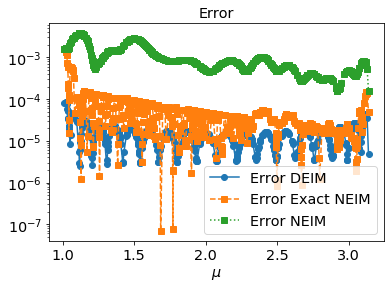

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 18, 49, 4, 33, 11, 47, 2, 37]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.38749079581801565
100 0.2835994690755513
200 0.19187768109281755
300 0.11799288284880559
400 0.0671707580194425
500 0.0358295908806141
600 0.018170439684707048
700 0.008920582180807489
800 0.004279255496307426
900 0.002003481990518314
1000 0.0009097575404081398
1100 0.0003977671152263634
1200 0.00016627434956556494
1300 6.60082556628612e-05
1400 2.4730420502513715e-05
1500 8.694628257554716e-06
1600 2.8537454834496168e-06
1700 8.702843415318996e-07
1800 2.454946504732563e-07
1900 6.378384046881798e-08
2000 1.520947332541406e-08
2100 3.327933291931401e-09
2200 6.798957929870443e-10
2300 1.435870404467847e-10
2400 4.4169106427805885e-11
2500 2.622514486784553e-11
2600 2.20390033078748e-11
2700 2.007756675036768e-11
2800 1.8580145344589176e-11
2900 1.7292321945735978e-11
3000 1.6165589009485452e-11
3100 1.5177757929477865e-11
3200

9500 3.1847069229630604e-12
9600 3.141441224918725e-12
9700 3.0999404184001194e-12
9800 3.0601245920669667e-12
9900 3.0219174599386036e-12
10000 2.9852461983114068e-12
10100 2.95004128983424e-12
10200 2.916236374721135e-12
10300 2.883768108490716e-12
10400 2.852576026272383e-12
10500 2.8226024128269483e-12
10600 2.7937921787707513e-12
10700 2.766092741979442e-12
10800 2.7394539145609304e-12
10900 2.7138277946005873e-12
11000 2.6891686630332726e-12
11100 2.6728785257722028e-12
11200 2.6480562406996366e-12
11300 2.630004948227965e-12
11400 2.6124913143913786e-12
11500 2.603253738792936e-12
11600 2.5839491864373525e-12
11700 2.5721246924223822e-12
11800 2.560551914983544e-12
11900 2.5492234275114357e-12
12000 2.5381327329222243e-12
12100 2.5272735062355524e-12
12200 2.5183617027406493e-12
12300 2.5105978611612306e-12
12400 2.5030767298155083e-12
12500 2.4956679347511036e-12
12600 2.488369304935382e-12
12700 2.4811787100567074e-12
12800 2.4806836172766182e-12
12900 2.468590261674908e-12
13

18400 1.611568569499177e-11
18500 1.6115677357810436e-11
18600 1.6115669020251222e-11
18700 1.6115660682409847e-11
18800 1.611565234410244e-11
18900 1.611564400550374e-11
19000 1.6115635666348027e-11
19100 1.6115627326854578e-11
19200 1.6115618986877913e-11
19300 1.611561064647302e-11
19400 1.6115602305492343e-11
19500 1.611559396403198e-11
19600 1.611558562198077e-11
19700 1.6115577279487117e-11
19800 1.6115568936202835e-11
19900 1.6115560592429457e-11

Finding theta...
50 Max Error: 10.256539689792294 Mean Error: 4.851368000706764
0 0.38847433313157337
100 0.23547114789798732
200 0.12388657384308231
300 0.060374926314326754
400 0.02791286513436195
500 0.012497810357787851
600 0.005582367040865817
700 0.002623006650912925
800 0.0014112004147220155
900 0.0009242910454076977
1000 0.0007166433161670914
1100 0.0006101007348466896
1200 0.00054005047310731
1300 0.00048503658236606195
1400 0.0004382394050896024
1500 0.00039731107240345207
1600 0.0003611761328206733
1700 0.0003291347281102333

7800 1.0567180130321311e-09
7900 1.0567178972703424e-09
8000 1.0567177814985106e-09
8100 1.0567176657177242e-09
8200 1.0567175499286696e-09
8300 1.05671743413202e-09
8400 1.0567173183286165e-09
8500 1.0567172025190615e-09
8600 1.056717086703724e-09
8700 1.0567169708831915e-09
8800 1.0567168550578857e-09
8900 1.0567167392284866e-09
9000 1.0567166233950248e-09
9100 1.0567165075580226e-09
9200 1.056716391717779e-09
9300 1.0567162758746448e-09
9400 1.0567161600287883e-09
9500 1.056716044180366e-09
9600 1.0567159283297066e-09
9700 1.0567158124768838e-09
9800 1.0567156966221438e-09
9900 1.0567155807656646e-09
10000 1.0567154649074439e-09
10100 1.0567153490476492e-09
10200 1.056715233186325e-09
10300 1.056715117323701e-09
10400 1.0567150014596705e-09
10500 1.0567148855943155e-09
10600 1.0567147697277843e-09
10700 1.0567146538599366e-09
10800 1.0567145379909306e-09
10900 1.05671442212067e-09
11000 1.056714306249341e-09
11100 1.0567141903766962e-09
11200 1.0567140745028837e-09
11300 1.056713958

17200 8.902636601801906e-10
17300 8.902635849731087e-10
17400 8.902635096375468e-10
17500 8.902634341688134e-10
17600 8.902633585620056e-10
17700 8.902632828124213e-10
17800 8.90263206915009e-10
17900 8.902631308646787e-10
18000 8.902630546562554e-10
18100 8.902629782845688e-10
18200 8.90262901744281e-10
18300 8.902628250297918e-10
18400 8.902627481357989e-10
18500 8.90262671056654e-10
18600 8.902625937866744e-10
18700 8.902625163200979e-10
18800 8.902624386510744e-10
18900 8.902623607739441e-10
19000 8.902622826824905e-10
19100 8.902622043707969e-10
19200 8.902621258329394e-10
19300 8.902620470625436e-10
19400 8.902619680536026e-10
19500 8.902618887998285e-10
19600 8.902618092950327e-10
19700 8.902617295326346e-10
19800 8.902616495063676e-10
19900 8.902615692096635e-10

Finding theta...
39 Max Error: 3.3835443727324708 Mean Error: 0.9280988107169643
0 0.5295411251060475
100 0.3802128983437705
200 0.27746990284832207
300 0.20069488104503572
400 0.14322570641183774
500 0.101293290265705

6500 2.0484947358053277e-09
6600 2.0484946520237677e-09
6700 2.048494564692337e-09
6800 2.0484944736329298e-09
6900 2.0484943786592977e-09
7000 2.0484942795762026e-09
7100 2.048494176178392e-09
7200 2.048494068250728e-09
7300 2.0484939555678187e-09
7400 2.0484938378934663e-09
7500 2.0484937149798357e-09
7600 2.0484935865669865e-09
7700 2.0484934523830624e-09
7800 2.048493312143085e-09
7900 2.048493165548423e-09
8000 2.0484930122864705e-09
8100 2.0484928520298585e-09
8200 2.0484926844357645e-09
8300 2.0484925091458227e-09
8400 2.048492325784597e-09
8500 2.048492133960011e-09
8600 2.048491933261423e-09
8700 2.048491723260008e-09
8800 2.048491503507315e-09
8900 2.0484912735352424e-09
9000 2.048491032854374e-09
9100 2.048490780954261e-09
9200 2.048490517302006e-09
9300 2.0484902413417627e-09
9400 2.0484899524937347e-09
9500 2.0484896501539632e-09
9600 2.048489333693099e-09
9700 2.0484890024559004e-09
9800 2.048488655760763e-09
9900 2.0484882928981942e-09
10000 2.0484879131313594e-09
10100 

15500 1.0947493610156308e-08
15600 1.0947488402985987e-08
15700 1.0947483505654308e-08
15800 1.0947478924014692e-08
15900 1.0947474661119018e-08
16000 1.0947470717141887e-08
16100 1.0947467089361035e-08
16200 1.0947463772198416e-08
16300 1.0947460757325084e-08
16400 1.0947458033828546e-08
16500 1.0947455588441923e-08
16600 1.0947453405828324e-08
16700 1.0947451468914373e-08
16800 1.09474497592624e-08
16900 1.0947448257469838e-08
17000 1.094744694358137e-08
17100 1.0947445797500669e-08
17200 1.0947444799386096e-08
17300 1.0947443930016036e-08
17400 1.0947443171112194e-08
17500 1.0947442505609328e-08
17600 1.0947441917864782e-08
17700 1.094744139380244e-08
17800 1.0947440920991167e-08
17900 1.094744048866153e-08
18000 1.0947440087664012e-08
18100 1.0947439710380878e-08
18200 1.0947439350599422e-08
18300 1.094743900335985e-08
18400 1.0947438664788339e-08
18500 1.094743833192634e-08
18600 1.0947438002565019e-08
18700 1.0947437675092686e-08
18800 1.0947437348358807e-08
18900 1.0947437021559

4900 5.627399998132416e-08
5000 5.6273998164854235e-08
5100 5.627399625867322e-08
5200 5.627399425834274e-08
5300 5.627399215920578e-08
5400 5.627398995637804e-08
5500 5.627398764473659e-08
5600 5.62739852189111e-08
5700 5.6273982673270384e-08
5800 5.627398000191299e-08
5900 5.6273977198654565e-08
6000 5.6273974257015594e-08
6100 5.627397117020931e-08
6200 5.6273967931127944e-08
6300 5.627396453233032e-08
6400 5.62739609660271e-08
6500 5.6273957224066824e-08
6600 5.6273953297921723e-08
6700 5.627394917867352e-08
6800 5.6273944856996636e-08
6900 5.6273940323143935e-08
7000 5.6273935566929906e-08
7100 5.627393057771647e-08
7200 5.6273925344394945e-08
7300 5.627391985537077e-08
7400 5.627391409854595e-08
7500 5.627390806130553e-08
7600 5.627390173049776e-08
7700 5.627389509241982e-08
7800 5.627388813280295e-08
7900 5.627388083679409e-08
8000 5.627387318894308e-08
8100 5.627386517318919e-08
8200 5.627385677284414e-08
8300 5.627384797058311e-08
8400 5.627383874843214e-08
8500 5.627382908775

14400 5.278330447108291e-07
14500 5.278323898650272e-07
14600 5.278317427789065e-07
14700 5.278311053626581e-07
14800 5.27830479534304e-07
14900 5.278298671999714e-07
15000 5.27829270232605e-07
15100 5.278286904493507e-07
15200 5.27828129587965e-07
15300 5.278275892826471e-07
15400 5.278270710397796e-07
15500 5.278265762141165e-07
15600 5.278261059860291e-07
15700 5.27825661340444e-07
15800 5.278252430481534e-07
15900 5.278248516501589e-07
16000 5.278244874457026e-07
16100 5.278241504845744e-07
16200 5.278238405642015e-07
16300 5.278235572319108e-07
16400 5.278232997925924e-07
16500 5.278230673218257e-07
16600 5.278228586843264e-07
16700 5.278226725573401e-07
16800 5.278225074584203e-07
16900 5.278223617767838e-07
17000 5.278222338072714e-07
17100 5.278221217857867e-07
17200 5.278220239249762e-07
17300 5.278219384488903e-07
17400 5.278218636253769e-07
17500 5.278217977950772e-07
17600 5.278217393960587e-07
17700 5.278216869833505e-07
17800 5.27821639242931e-07
17900 5.278215950000171e-

4100 9.220058904477357e-05
4200 9.220058320772581e-05
4300 9.220057706749195e-05
4400 9.220057060884853e-05
4500 9.22005638157908e-05
4600 9.220055667149447e-05
4700 9.220054915827592e-05
4800 9.22005412575503e-05
4900 9.220053294978793e-05
5000 9.220052421446824e-05
5100 9.220051503003201e-05
5200 9.220050537383128e-05
5300 9.220049522207692e-05
5400 9.220048454978417e-05
5500 9.220047333071538e-05
5600 9.220046153732082e-05
5700 9.220044914067645e-05
5800 9.220043611041974e-05
5900 9.220042241468256e-05
6000 9.220040802002118e-05
6100 9.220039289134444e-05
6200 9.220037699183856e-05
6300 9.220036028288963e-05
6400 9.220034272400349e-05
6500 9.220032427272287e-05
6600 9.220030488454254e-05
6700 9.220028451282151e-05
6800 9.220026310869353e-05
6900 9.220024062097518e-05
7000 9.220021699607263e-05
7100 9.220019217788644e-05
7200 9.22001661077155e-05
7300 9.220013872416018e-05
7400 9.220010996302526e-05
7500 9.220007975722321e-05
7600 9.220004803667832e-05
7700 9.220001472823261e-05
7800

13600 1.7972825368779692e-07
13700 1.7972809187525203e-07
13800 1.7972792885492884e-07
13900 1.7972776496953514e-07
14000 1.797276005854992e-07
14100 1.7972743609169237e-07
14200 1.7972727189775178e-07
14300 1.7972710843192942e-07
14400 1.7972694613848268e-07
14500 1.7972678547458226e-07
14600 1.7972662690672206e-07
14700 1.7972647090665384e-07
14800 1.79726317946867e-07
14900 1.797261684956264e-07
15000 1.7972602301165418e-07
15100 1.79725881938496e-07
15200 1.797257456986804e-07
15300 1.7972561468775635e-07
15400 1.797254892683557e-07
15500 1.7972536976439262e-07
15600 1.7972525645558324e-07
15700 1.7972514957242194e-07
15800 1.797250492917978e-07
15900 1.7972495573340268e-07
16000 1.7972486895709974e-07
16100 1.7972478896139478e-07
16200 1.7972471568311654e-07
16300 1.7972464899840575e-07
16400 1.7972458872503285e-07
16500 1.7972453462609473e-07
16600 1.7972448641496683e-07
16700 1.7972444376145683e-07
16800 1.7972440629899278e-07
16900 1.7972437363259364e-07
17000 1.797243453474136

2600 0.0017352132771440423
2700 0.0017298225006398685
2800 0.0017236975879219459
2900 0.0017167232100559016
3000 0.0017087649405372236
3100 0.0016996665383568477
3200 0.0016892471594067678
3300 0.0016772986850324347
3400 0.001663583466653997
3500 0.0016478329318538045
3600 0.0016297476820715448
3700 0.0016089999287580573
3800 0.0015852393415710286
3900 0.0015581035697435398
4000 0.0015272347534153105
4100 0.0014923031117955398
4200 0.0014530379606917214
4300 0.0014092650350765836
4400 0.001360946670163861
4500 0.0013082185531108953
4600 0.0012514144526635101
4700 0.001191070247537234
4800 0.0011279020643270002
4900 0.0010627599522378666
5000 0.0009965654634379174
5100 0.000930245269453323
5200 0.0008646720231952689
5300 0.0008006195265431938
5400 0.0007387345970677786
5500 0.0006795246307835814
5600 0.0006233580360424018
5700 0.0005704740555777333
5800 0.0005209985662476532
5900 0.0004749629352685454
6000 0.0004323236660335213
6100 0.0003929812050197098
6200 0.0003567968228741864
6300 

12300 0.001143507476482029
12400 0.0011435073313844717
12500 0.001143507185204613
12600 0.0011435070378929529
12700 0.001143506889397696
12800 0.001143506739664687
12900 0.0011435065886373527
13000 0.001143506436256654
13100 0.0011435062824610425
13200 0.0011435061271864333
13300 0.0011435059703661845
13400 0.0011435058119310907
13500 0.0011435056518093979
13600 0.0011435054899268265
13700 0.0011435053262066218
13800 0.001143505160569621
13900 0.0011435049929343476
14000 0.0011435048232171288
14100 0.0011435046513322397
14200 0.0011435044771920845
14300 0.0011435043007073983
14400 0.0011435041217874907
14500 0.0011435039403405172
14600 0.0011435037562737827
14700 0.001143503569494082
14800 0.0011435033799080657
14900 0.0011435031874226344
15000 0.001143502991945358
15100 0.0011435027933849105
15200 0.0011435025916515173
15300 0.0011435023866574077
15400 0.0011435021783172594
15500 0.0011435019665486325
15600 0.001143501751272377
15700 0.0011435015324130083
15800 0.0011435013098990375
1

2600 0.015045048139970442
2700 0.014457902011311611
2800 0.013879124424809958
2900 0.013316138927923405
3000 0.01277774816329801
3100 0.012272957640263938
3200 0.01180961176012209
3300 0.011393269196064303
3400 0.011026660890610855
3500 0.010709798671557883
3600 0.010440532107055669
3700 0.010215254889412622
3800 0.01002953944058238
3900 0.009878612767047875
4000 0.009757680660588202
4100 0.00966214033577093
4200 0.009587718023721449
4300 0.009530554680428254
4400 0.009487252699564202
4500 0.009454891473657702
4600 0.009431017961509415
4700 0.00941361808759184
4800 0.009401074693306314
4900 0.009392381701559288
5000 0.009388373273512364
5100 0.009386784980713228
5200 0.009386149238130278
5300 0.00938589427420902
5400 0.009385792890342203
5500 0.0093857522429973
5600 0.009385735893147833
5700 0.009385729308305196
5800 0.00938572665507037
5900 0.009385725578277451
6000 0.009385724798687338
6100 0.009385723979758905
6200 0.009385723119521704
6300 0.009385722215911226
6400 0.00938572126676

13700 0.00951834842918175
13800 0.00951833938037669
13900 0.009518330265391986
14000 0.009518321088952855
14100 0.00951831185561596
14200 0.009518302569759557
14300 0.009518293235576318
14400 0.00951828385706874
14500 0.009518274438046974
14600 0.009518264982128875
14700 0.009518255492742028
14800 0.009518245973127507
14900 0.00951823642634505
15000 0.009518226855279413
15100 0.009518217262647554
15200 0.00951820765100642
15300 0.009518198022761003
15400 0.009518188380172545
15500 0.009518178725366536
15600 0.009518169060340474
15700 0.009518159386971162
15800 0.009518149707021499
15900 0.009518140022146708
16000 0.009518130333899965
16100 0.009518120643737481
16200 0.009518110953023042
16300 0.0095181012630321
16400 0.00951809157495547
16500 0.00951808188990272
16600 0.00951807220890534
16700 0.009518062532919752
16800 0.009518052862830254
16900 0.009518043199451903
17000 0.009518033543533467
17100 0.009518023895760385
17200 0.009518014256757837
17300 0.009518004627093889
17400 0.0095

4600 0.03132192802624651
4700 0.031321922818366814
4800 0.031321917387382145
4900 0.03132191172540755
5000 0.031321905824380984
5100 0.031321899676065725
5200 0.031321893272053834
5300 0.03132188660377102
5400 0.03132187966248298
5500 0.03132187243930358
5600 0.0313218649252049
5700 0.031321857111029416
5800 0.031321848987504244
5900 0.03132184054525764
6000 0.03132183177483754
6100 0.03132182266673236
6200 0.031321813211393726
6300 0.031321803399261175
6400 0.03132179322078853
6500 0.03132178266647205
6600 0.03132177172688004
6700 0.031321760392683654
6800 0.03132174865468911
6900 0.03132173650387086
7000 0.031321723931405754
7100 0.03132171092870794
7200 0.031321697487464537
7300 0.03132168359967165
7400 0.03132166925767079
7500 0.03132165445418519
7600 0.03132163918235578
7700 0.031321623435776616
7800 0.031321607208529056
7900 0.03132159049521441
8000 0.03132157329098466
8100 0.03132155559157068
8200 0.03132153739330768
8300 0.03132151869315755
8400 0.031321499488728005
8500 0.0313

15900 0.007981487852148809
16000 0.007981478909360193
16100 0.007981469947638594
16200 0.007981460968991385
16300 0.007981451975329984
16400 0.007981442968472635
16500 0.007981433950147164
16600 0.007981424921993718
16700 0.007981415885567453
16800 0.007981406842341148
16900 0.007981397793707774
17000 0.007981388740983038
17100 0.007981379685407847
17200 0.007981370628150786
17300 0.007981361570310578
17400 0.007981352512918517
17500 0.00798134345694093
17600 0.007981334403281646
17700 0.007981325352784466
17800 0.007981316306235643
17900 0.007981307264366378
18000 0.007981298227855309
18100 0.007981289197330996
18200 0.00798128017337439
18300 0.007981271156521289
18400 0.007981262147264755
18500 0.00798125314605749
18600 0.007981244153314174
18700 0.007981235169413743
18800 0.007981226194701603
18900 0.007981217229491779
19000 0.007981208274068981
19100 0.007981199328690614
19200 0.007981190393588668
19300 0.007981181468971556
19400 0.00798117255502585
19500 0.007981163651917925
19600

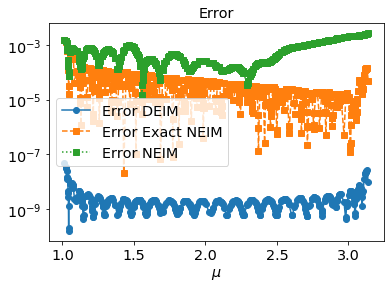

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 18, 49, 4, 33, 11, 47, 2, 37, 44, 7, 23, 46, 14]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.4316800614242237
100 0.23861852384280968
200 0.1650539142271998
300 0.12030914905858049
400 0.08741377206141618
500 0.06300144820304401
600 0.04500690329793371
700 0.03185910935954974
800 0.02233537217380488
900 0.01549400368172004
1000 0.010620701843961727
1100 0.007180836289401931
1200 0.004778403794579232
1300 0.003122001785204084
1400 0.0019977939244082664
1500 0.001249045103785557
1600 0.0007612081000772927
1700 0.0004511996653933182
1800 0.0002595780662843025
1900 0.00014465625248668838
2000 7.793678883401946e-05
2100 4.0519666826387215e-05
2200 2.0290390568830973e-05
2300 9.767551577323642e-06
2400 4.511218262950506e-06
2500 1.9948788083412848e-06
2600 8.427598279920092e-07
2700 3.3934737315041154e-07
2800 1.299146273114252e-07
2900 4.7161767548166786e-08
3000 1.618881837779134e-08
3100 5.2392086149455

9300 3.7377065550206697e-13
9400 3.737706220016139e-13
9500 3.7377059339760947e-13
9600 3.7377056479197496e-13
9700 3.737705361810295e-13
9800 3.737705075704851e-13
9900 3.7377047895389915e-13
10000 3.7377045034013843e-13
10100 3.737704217211672e-13
10200 3.7377039310841123e-13
10300 3.737703644837534e-13
10400 3.73770335864225e-13
10500 3.7377030724393915e-13
10600 3.737702786224593e-13
10700 3.7377024999261876e-13
10800 3.737702213650363e-13
10900 3.7377019273790574e-13
11000 3.7377016411158045e-13
11100 3.737701354809636e-13
11200 3.7377010685201926e-13
11300 3.737700782190852e-13
11400 3.737700495907316e-13
11500 3.7377002095280085e-13
11600 3.737699923280043e-13
11700 3.7376996368954773e-13
11800 3.737699350525463e-13
11900 3.7376990641814933e-13
12000 3.737698777811583e-13
12100 3.7376984914188725e-13
12200 3.7376982050970743e-13
12300 3.737697918716839e-13
12400 3.737697632359945e-13
12500 3.7376973458868506e-13
12600 3.737697059578572e-13
12700 3.7376967731455884e-13
12800 3.73

18400 1.6599979812104896e-12
18500 1.6599956739287455e-12
18600 1.6599933665371018e-12
18700 1.6599910590526671e-12
18800 1.6599887514788278e-12
18900 1.65998644373899e-12
19000 1.6599841358828687e-12
19100 1.659981827937287e-12
19200 1.6599795197937344e-12
19300 1.6599772115164885e-12
19400 1.6599749030909244e-12
19500 1.6599725944755914e-12
19600 1.6599702857118944e-12
19700 1.6599679767640031e-12
19800 1.6599656675896471e-12
19900 1.659963358253008e-12

Finding theta...
50 Max Error: 10.256539689311435 Mean Error: 4.851367998384533
0 0.3099021965193544
100 0.1902985169891106
200 0.12339446355601832
300 0.07445681313852265
400 0.042036741730763695
500 0.02263508335742582
600 0.011749819231580094
700 0.005894686636652273
800 0.0028549793370384103
900 0.0013315137689320507
1000 0.0005962612242780184
1100 0.0002556536706412988
1200 0.00010464909624059677
1300 4.076489670532238e-05
1400 1.5055502609175391e-05
1500 5.249741601395412e-06
1600 1.7203180817945596e-06
1700 5.271964057071734e-

7900 2.8529148913501326e-12
8000 2.8442423068641496e-12
8100 2.8356574493233947e-12
8200 2.8271574221437336e-12
8300 2.8187394618365134e-12
8400 2.810400931489543e-12
8500 2.802139314415979e-12
8600 2.7939522085006955e-12
8700 2.7858373206156098e-12
8800 2.7777924613293086e-12
8900 2.769815540086708e-12
9000 2.761904560449495e-12
9100 2.754057615655782e-12
9200 2.7462728843557514e-12
9300 2.7385486266809173e-12
9400 2.7308831802841816e-12
9500 2.723274956829667e-12
9600 2.715722438425491e-12
9700 2.7082241744162855e-12
9800 2.7031875877359373e-12
9900 2.695918501124418e-12
10000 2.6905479737491908e-12
10100 2.685203954055433e-12
10200 2.6798859092231194e-12
10300 2.6745933919204037e-12
10400 2.6695968274580912e-12
10500 2.66511712814297e-12
10600 2.660884377130603e-12
10700 2.656667613724833e-12
10800 2.7299577486393765e-12
10900 2.6495456583215534e-12
11000 2.6468045398584694e-12
11100 2.6440700723483426e-12
11200 2.641342037036842e-12
11300 2.63862038184465e-12
11400 2.63590505547199

17100 3.6488941696386085e-12
17200 3.648891654686559e-12
17300 3.6488891394717576e-12
17400 3.648886623946032e-12
17500 3.6488841081217016e-12
17600 3.6488815919545076e-12
17700 3.648879075464571e-12
17800 3.6488765585837664e-12
17900 3.648874041349523e-12
18000 3.648871523695589e-12
18100 3.648869005645838e-12
18200 3.648866487110715e-12
18300 3.648863968184665e-12
18400 3.648861448718452e-12
18500 3.648858928777306e-12
18600 3.648856408306549e-12
18700 3.648853887282587e-12
18800 3.648851365652198e-12
18900 3.6488488434347994e-12
19000 3.648846320563085e-12
19100 3.648843797033346e-12
19200 3.648841272801308e-12
19300 3.648838747849551e-12
19400 3.648836222111104e-12
19500 3.6488336955800844e-12
19600 3.648831168193498e-12
19700 3.648828639961401e-12
19800 3.648826110791939e-12
19900 3.648823580667912e-12

Finding theta...
39 Max Error: 3.383539638191322 Mean Error: 0.9280959070912059
0 0.38858753156600395
100 0.24648486371840028
200 0.1646622472303404
300 0.10619227879518284
400 0.0

6200 3.1908530799407436e-06
6300 3.0213485425716806e-06
6400 2.861331235474277e-06
6500 2.7102274623613936e-06
6600 2.5674979080820546e-06
6700 2.4326455678409674e-06
6800 2.305202273332034e-06
6900 2.1847485879368097e-06
7000 2.070825836596684e-06
7100 1.963101663486177e-06
7200 1.861203141980826e-06
7300 1.7647949789958139e-06
7400 1.6735642624489915e-06
7500 1.587227388084112e-06
7600 1.5054712904125265e-06
7700 1.4280755380807251e-06
7800 1.354783648727902e-06
7900 1.285368663977464e-06
8000 1.2196180139925695e-06
8100 1.157312732855586e-06
8200 1.0982828363039719e-06
8300 1.0423865581997915e-06
8400 9.893222889813653e-07
8500 9.391676374460159e-07
8600 8.914192647822457e-07
8700 8.477360702383816e-07
8800 8.034110171672396e-07
8900 7.62789803159745e-07
9000 7.242888020218084e-07
9100 6.877217638947326e-07
9200 6.530589936439867e-07
9300 6.201732864851379e-07
9400 5.889735693585176e-07
9500 5.593708774755195e-07
9600 5.314435559280315e-07
9700 5.04621509307959e-07
9800 4.7932201239

15900 5.868373097207572e-10
16000 5.868372635741786e-10
16100 5.86837217422546e-10
16200 5.86837171265602e-10
16300 5.868371251029361e-10
16400 5.868370789344277e-10
16500 5.868370327596226e-10
16600 5.86836986578287e-10
16700 5.868369403901263e-10
16800 5.868368941947986e-10
16900 5.86836847991792e-10
17000 5.868368017808915e-10
17100 5.868367555615576e-10
17200 5.868367093334386e-10
17300 5.868366630960977e-10
17400 5.868366168491271e-10
17500 5.868365705919084e-10
17600 5.868365243241576e-10
17700 5.868364780451416e-10
17800 5.868364317544358e-10
17900 5.868363854515239e-10
18000 5.868363391356775e-10
18100 5.868362928063649e-10
18200 5.868362464629976e-10
18300 5.868362001047928e-10
18400 5.868361537311269e-10
18500 5.868361073412446e-10
18600 5.868360609344585e-10
18700 5.868360145098763e-10
18800 5.86835968066784e-10
18900 5.868359216042933e-10
19000 5.868358751215221e-10
19100 5.868358286175762e-10
19200 5.868357820914313e-10
19300 5.868357355422001e-10
19400 5.868356889688636e-

5200 7.563177209058478e-09
5300 7.563176773521095e-09
5400 7.563176334594792e-09
5500 7.563175892146462e-09
5600 7.563175446035636e-09
5700 7.563174996111875e-09
5800 7.563174542216568e-09
5900 7.56317408418069e-09
6000 7.563173621825957e-09
6100 7.563173154964096e-09
6200 7.563172683395785e-09
6300 7.563172206911673e-09
6400 7.563171725290675e-09
6500 7.563171238300848e-09
6600 7.563170745697473e-09
6700 7.563170247224363e-09
6800 7.563169742611783e-09
6900 7.56316923157756e-09
7000 7.563168713825878e-09
7100 7.563168189046322e-09
7200 7.563167656914625e-09
7300 7.563167117091505e-09
7400 7.563166569221632e-09
7500 7.563166012934864e-09
7600 7.563165447844485e-09
7700 7.563164873546755e-09
7800 7.563164289621192e-09
7900 7.563163695629325e-09
8000 7.563163091114936e-09
8100 7.563162475603861e-09
8200 7.563161848602163e-09
8300 7.563161209598379e-09
8400 7.563160558060078e-09
8500 7.563159893436323e-09
8600 7.563159215156069e-09
8700 7.563158522627986e-09
8800 7.563157815241458e-09
890

14600 1.450846271190697e-09
14700 1.4508461373250919e-09
14800 1.4508460047869262e-09
14900 1.450845873657551e-09
15000 1.450845744008101e-09
15100 1.4508456158980406e-09
15200 1.4508454893744262e-09
15300 1.4508453644706507e-09
15400 1.4508452412057689e-09
15500 1.450845119584398e-09
15600 1.4508449995962207e-09
15700 1.450844881216272e-09
15800 1.4508447644050964e-09
15900 1.4508446491103023e-09
16000 1.4508445352667601e-09
16100 1.4508444227985863e-09
16200 1.450844311620393e-09
16300 1.4508442016395708e-09
16400 1.4508440927579678e-09
16500 1.4508439848739067e-09
16600 1.45084387788471e-09
16700 1.4508437716880312e-09
16800 1.4508436661844807e-09
16900 1.4508435612787237e-09
17000 1.4508434568813329e-09
17100 1.4508433529096413e-09
17200 1.4508432492886893e-09
17300 1.4508431459518299e-09
17400 1.450843042840433e-09
17500 1.4508429399044286e-09
17600 1.4508428371014675e-09
17700 1.4508427343964599e-09
17800 1.4508426317609861e-09
17900 1.450842529172316e-09
18000 1.4508424266127448

3400 1.639030224155641e-08
3500 1.63901634812119e-08
3600 1.6390109361432676e-08
3700 1.6390088245083817e-08
3800 1.6390080007056988e-08
3900 1.639007679426584e-08
4000 1.6390075376446734e-08
4100 1.63900740729224e-08
4200 1.6390072749637522e-08
4300 1.6390071406703915e-08
4400 1.639007004421806e-08
4500 1.6390068662259554e-08
4600 1.639006726089101e-08
4700 1.639006584015539e-08
4800 1.6390064400076412e-08
4900 1.639006294065628e-08
5000 1.6390061461875085e-08
5100 1.6390059963690102e-08
5200 1.6390058446033572e-08
5300 1.639005690881324e-08
5400 1.6390055351910288e-08
5500 1.639005377517885e-08
5600 1.639005217844595e-08
5700 1.639005056150933e-08
5800 1.639004892413907e-08
5900 1.6390047266075176e-08
6000 1.639004558702847e-08
6100 1.6390043886679757e-08
6200 1.63900421646813e-08
6300 1.6390040420655222e-08
6400 1.6390038654194954e-08
6500 1.63900368648653e-08
6600 1.6390035052203896e-08
6700 1.639003321572101e-08
6800 1.6390031354901845e-08
6900 1.6390029469205906e-08
7000 1.639002

12600 1.6031708542679374e-06
12700 1.5904325066679499e-06
12800 1.5840594468944755e-06
12900 1.5782500511675357e-06
13000 1.5729564683940766e-06
13100 1.5678647959698018e-06
13200 1.5629519102581417e-06
13300 1.5597647904976266e-06
13400 1.5540969414693987e-06
13500 1.5501195057681711e-06
13600 1.5462605148807197e-06
13700 1.5428908230713953e-06
13800 1.5396683343319467e-06
13900 1.536580777590544e-06
14000 1.5338113049741569e-06
14100 1.5310928769303639e-06
14200 1.5285982375724705e-06
14300 1.5262387513767433e-06
14400 1.5239115953541194e-06
14500 1.5220433585360418e-06
14600 1.519585263529897e-06
14700 1.5175794861610108e-06
14800 1.515593234117697e-06
14900 1.5136272972177815e-06
15000 1.5118054518490134e-06
15100 1.5101233035967469e-06
15200 1.5088361863230347e-06
15300 1.5072396698868617e-06
15400 1.5066024908766423e-06
15500 1.5062832625155662e-06
15600 1.5061475971560212e-06
15700 1.5060926249388954e-06
15800 1.5060704029228414e-06
15900 1.5060614577971015e-06
16000 1.506057850

1400 4.311335094887927e-05
1500 1.80651817945169e-05
1600 7.954145640585692e-06
1700 4.1188383067300536e-06
1800 2.7570824369959312e-06
1900 2.306280259769953e-06
2000 2.167652797515819e-06
2100 2.1281566776706486e-06
2200 2.1177080379087803e-06
2300 2.1151310916556167e-06
2400 2.114612508218327e-06
2500 2.1144747804449047e-06
2600 2.1144297892737407e-06
2700 2.1144132491850095e-06
2800 2.1144068706989756e-06
2900 2.1144043645509473e-06
3000 2.114403372365616e-06
3100 2.1144029783053076e-06
3200 2.1144028215784824e-06
3300 2.11440275763001e-06
3400 2.114402707248475e-06
3500 2.114402654937323e-06
3600 2.1144026006069065e-06
3700 2.1144025441625147e-06
3800 2.1144024855041846e-06
3900 2.114402424526466e-06
4000 2.1144023611181696e-06
4100 2.1144022951621445e-06
4200 2.1144022265349935e-06
4300 2.1144021551068057e-06
4400 2.1144020807408556e-06
4500 2.1144020032933146e-06
4600 2.1144019226129232e-06
4700 2.114401838540655e-06
4800 2.1144017509093663e-06
4900 2.1144016595434324e-06
5000 2

11000 0.0009200360356553886
11100 0.0009200349596420865
11200 0.0009200338645998239
11300 0.0009200327510276383
11400 0.0009200316194662082
11500 0.0009200304704964744
11600 0.0009200293047377266
11700 0.0009200281228451746
11800 0.0009200269255070287
11900 0.0009200257134411315
12000 0.0009200244873911936
12100 0.0009200232481226932
12200 0.0009200219964185035
12300 0.0009200207330743258
12400 0.0009200194588939994
12500 0.0009200181746847651
12600 0.0009200168812525574
12700 0.0009200155793974012
12800 0.0009200142699089745
12900 0.0009200129535624116
13000 0.0009200116311143898
13100 0.0009200103032995576
13200 0.0009200089708273387
13300 0.0009200076343791436
13400 0.0009200062946060048
13500 0.0009200049521266486
13600 0.0009200036075260069
13700 0.0009200022613541534
13800 0.0009200009141256577
13900 0.0009199995663193318
14000 0.0009199982183783457
14100 0.0009199968707106829
14200 0.000919995523689907
14300 0.0009199941776562115
14400 0.0009199928329177185
14500 0.0009199914897

19900 0.00011097523789582724

Finding theta...
2 Max Error: 2.1458086155241353e-07 Mean Error: 3.106524248837017e-08
0 0.33039540311408033
100 0.18722713692984363
200 0.11571929049610334
300 0.07737966242366161
400 0.05518846352820824
500 0.041944692399994696
600 0.03405525741069019
700 0.02937840747886253
800 0.02657308828722597
900 0.024814328474828465
1000 0.02360954428237877
1100 0.02267334837678476
1200 0.02184544190635289
1300 0.02103971448752293
1400 0.02021364777389304
1500 0.019349851457190877
1600 0.018444753301948762
1700 0.017501767260310285
1800 0.01652757237145549
1900 0.015530614145059993
2000 0.014520817632239455
2100 0.01350941162538252
2200 0.01250818736072895
2300 0.011528211820725727
2400 0.010578515262015278
2500 0.009665329711139103
2600 0.008792136657075995
2700 0.007960389500581642
2800 0.0071705572042842615
2900 0.0064231225163124605
3000 0.005719269216186448
3100 0.005061168391556347
3200 0.0044521357287090405
3300 0.0038975335434202705
3400 0.0034069683131692

10100 0.004265991687076526
10200 0.004265989378953814
10300 0.004265988466291055
10400 0.004265987987493116
10500 0.004265987501508344
10600 0.004265986999720753
10700 0.0042659864813487545
10800 0.004265985945588121
10900 0.004265985391611303
11000 0.004265984818567017
11100 0.0042659842255800265
11200 0.004265983611751224
11300 0.004265982976157933
11400 0.004265982317854509
11500 0.0042659816358732484
11600 0.0042659809292256165
11700 0.004265980196903826
11800 0.0042659794378828095
11900 0.0042659786511225935
12000 0.004265977835571111
12100 0.004265976990167486
12200 0.004265976113845784
12300 0.0042659752055392965
12400 0.004265974264185329
12500 0.004265973288730514
12600 0.00426597227813667
12700 0.00426597123138718
12800 0.004265970147493873
12900 0.0042659690255044055
13000 0.004265967864510093
13100 0.004265966663654136
13200 0.004265965422140209
13300 0.0042659641392413
13400 0.004265962814308742
13500 0.004265961446781304
13600 0.004265960036194219
13700 0.0042659585821879

300 0.2187360576575022
400 0.16359531984919937
500 0.12121796134214134
600 0.08985417975758993
700 0.06775287640781757
800 0.05297691767257398
900 0.0435939037968893
1000 0.037898504640824435
1100 0.03456498496741306
1200 0.03267208354885679
1300 0.031627682408678755
1400 0.03106841574314724
1500 0.030777980995621998
1600 0.030631287232315285
1700 0.030558383175252904
1800 0.030521637699904652
1900 0.03050624490942978
2000 0.030500690150184095
2100 0.030498555580383842
2200 0.030497714725929687
2300 0.03049736884154889
2400 0.030497230289678524
2500 0.030497174564171777
2600 0.0304971521214254
2700 0.030497143086262515
2800 0.0304971394434053
2900 0.030497137430360456
3000 0.030497135337570317
3100 0.030497133141068788
3200 0.03049713083614257
3300 0.03049712841782537
3400 0.030497125880888525
3500 0.030497123219831654
3600 0.030497120428873196
3700 0.03049711750194089
3800 0.030497114432662377
3900 0.030497111214355853
4000 0.030497107840020903
4100 0.03049710430232964
4200 0.03049710

11700 0.028744767936328134
11800 0.02874475524194459
11900 0.028744742423688224
12000 0.028744729487830262
12100 0.028744716440815374
12200 0.028744703289221105
12300 0.02874469003971661
12400 0.028744676699021678
12500 0.028744663273866634
12600 0.02874464977095381
12700 0.028744636196921126
12800 0.02874462255830827
12900 0.028744608861525762
13000 0.0287445951128273
13100 0.028744581318285403
13200 0.028744567483770533
13300 0.02874455361493371
13400 0.028744539717192527
13500 0.028744525795720455
13600 0.02874451185543928
13700 0.02874449790101454
13800 0.028744483936853568
13900 0.02874446996710608
14000 0.028744455995666947
14100 0.028744442026180886
14200 0.02874442806204881
14300 0.028744414106435603
14400 0.028744400162279044
14500 0.028744386232299596
14600 0.028744372319010877
14700 0.028744358424730564
14800 0.02874434455159156
14900 0.028744330701553175
15000 0.02874431687641223
15100 0.028744303077813865
15200 0.028744289307262007
15300 0.028744275566129327
15400 0.028744

2600 0.03266657860786854
2700 0.03266657639143627
2800 0.03266657406907237
2900 0.032666571636935704
3000 0.032666569091031196
3100 0.03266656642720435
3200 0.03266656364113536
3300 0.032666560728332926
3400 0.03266655768412784
3500 0.032666554503666616
3600 0.032666551181905285
3700 0.03266654771360342
3800 0.03266654409331894
3900 0.03266654031540352
4000 0.032666536373999196
4100 0.03266653226303624
4200 0.032666527976232616
4300 0.03266652350709534
4400 0.032666518848923874
4500 0.03266651399481607
4600 0.0326665089376766
4700 0.03266650367022838
4800 0.032666498185027176
4900 0.03266649247447945
5000 0.03266648653086385
5100 0.032666480346356365
5200 0.03266647391305936
5300 0.032666467223034436
5400 0.03266646026833938
5500 0.032666453041068806
5600 0.032666445533398786
5700 0.03266643773763479
5800 0.032666429646263054
5900 0.032666421252004585
6000 0.03266641254787135
6100 0.03266640352722409
6200 0.032666394183830647
6300 0.0326663845119241
6400 0.03266637450625952
6500 0.0326

14400 0.03241313077810203
14500 0.032413103760840875
14600 0.03241307675105953
14700 0.032413049751672855
14800 0.032413022765498394
14900 0.032412995795259775
15000 0.03241296884358839
15100 0.032412941913023394
15200 0.03241291500601066
15300 0.03241288812490062
15400 0.03241286127194573
15500 0.032412834449297726
15600 0.03241280765900509
15700 0.032412780903010995
15800 0.03241275418315184
15900 0.03241272750115659
16000 0.03241270085864679
16100 0.03241267425713744
16200 0.032412647698038595
16300 0.03241262118265757
16400 0.03241259471220172
16500 0.03241256828778166
16600 0.0324125419104149
16700 0.03241251558102969
16800 0.032412489300469055
16900 0.03241246306949497
17000 0.03241243688879249
17100 0.032412410758974004
17200 0.032412384680583356
17300 0.032412358654099846
17400 0.032412332679942285
17500 0.03241230675847282
17600 0.03241228089000067
17700 0.032412255074785845
17800 0.03241222931304262
17900 0.03241220360494306
18000 0.032412177950620326
18100 0.0324121523501719

5500 0.03296171073011906
5600 0.032961704000226605
5700 0.03296169702591952
5800 0.03296168979952953
5900 0.03296168231331392
6000 0.03296167455948985
6100 0.0329616665302723
6200 0.03296165821791584
6300 0.032961649614759864
6400 0.03296164071327686
6500 0.0329616315061236
6600 0.03296162198619437
6700 0.0329616121466759
6800 0.03296160198110304
6900 0.032961591483414564
7000 0.0329615806480079
7100 0.032961569469792104
7200 0.03296155794423775
7300 0.03296154606742294
7400 0.03296153383607421
7500 0.03296152124760167
7600 0.03296150830012722
7700 0.03296149499250541
7800 0.032961481324336364
7900 0.03296146729597045
8000 0.0329614529085046
8100 0.03296143816377044
8200 0.03296142306431462
8300 0.03296140761337176
8400 0.03296139181483092
8500 0.032961375673196326
8600 0.032961359193543455
8700 0.032961342381471394
8800 0.03296132524305272
8900 0.03296130778478191
9000 0.03296129001352311
9100 0.032961271936458536
9200 0.032961253561038
9300 0.03296123489493035
9400 0.0329612159459773

17100 0.033018972570778356
17200 0.03301894784095043
17300 0.03301892317735204
17400 0.03301889858013754
17500 0.033018874049389885
17600 0.03301884958512297
17700 0.03301882518728364
17800 0.033018800855753504
17900 0.03301877659035055
18000 0.033018752390830686
18100 0.033018728256889236
18200 0.03301870418816254
18300 0.033018680184229966
18400 0.0330186562446165
18500 0.0330186323687962
18600 0.03301860855619701
18700 0.03301858480620726
18800 0.03301856111818402
18900 0.03301853749146367
19000 0.033018513925374256
19100 0.03301849041924918
19200 0.033018466972441124
19300 0.0330184435843347
19400 0.033018420254356556
19500 0.0330183969819814
19600 0.033018373766733625
19700 0.03301835060818454
19800 0.03301832750594618
19900 0.03301830445966289

Finding theta...
[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 11, 49, 2, 4, 10, 8, 5, 17, 7, 18, 15, 19, 12]


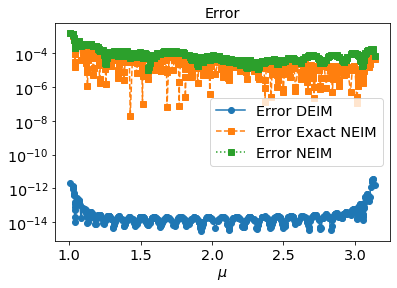

In [8]:
MAX_MODES = 30
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

test_mu = np.sort(np.random.uniform(size=500)*(np.pi-1)+1)
DEIM_errors = []
Exact_NEIM_errors = []
Actual_NEIM_errors = []
for num_modes in range(5, MAX_MODES+1, 5):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    Exact_NEIM_approximation, Exact_NEIM_selected_indices = Exact_NEIM(mu.reshape(-1), f, V[:, :RO_DIM], num_modes)
    print(Exact_NEIM_selected_indices)
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=20000) 
    print(NEIM_selected_indices)
    
    exact = V[:, :RO_DIM].T @ s(x, test_mu)
    DEIM_approximation = V[:, :RO_DIM].T @ DEIM_proj @ s(x, test_mu)
    Degenerate_NEIM_approximation = np.array([V[:, :RO_DIM].T @ Exact_NEIM_approximation(new_mu, num_modes) for new_mu in test_mu.reshape(-1)])[:, :, 0].T
    Actual_NEIM_approximation = np.array([V[:, :RO_DIM].T @ NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ solution_fn(np.array([[new_mu]]), s(x, new_mu)).reshape(-1, 1)).reshape(-1), num_modes) for new_mu in test_mu.reshape(-1)]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Exact_NEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', label="Error DEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', linestyle='dashed', label="Error Exact NEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', linestyle='dotted', label="Error NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.savefig(f'./Paper Figures/error_{num_modes}_experiment_1.pdf', bbox_inches='tight', dpi=500)
    with open(f"./Paper Data/error_{num_modes}_experiment_1_x.npy", 'wb') as file_obj:
        np.save(file_obj, test_mu.reshape(-1))
    with open(f"./Paper Data/error_{num_modes}_experiment_1_deim.npy", 'wb') as file_obj:
        np.save(file_obj, [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    with open(f"./Paper Data/error_{num_modes}_experiment_1_exact_neim.npy", 'wb') as file_obj:
        np.save(file_obj, [np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    with open(f"./Paper Data/error_{num_modes}_experiment_1_neim.npy", 'wb') as file_obj:
        np.save(file_obj, [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    plt.show()

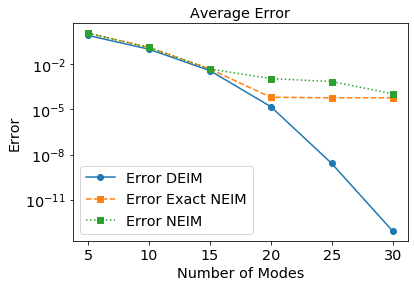

In [9]:
plt.plot(np.arange(5, MAX_MODES+1, 5), DEIM_errors, marker='o', label="Error DEIM")
plt.plot(np.arange(5, MAX_MODES+1, 5), Exact_NEIM_errors, marker='s', linestyle='dashed', label="Error Exact NEIM")
plt.plot(np.arange(5, MAX_MODES+1, 5), Actual_NEIM_errors, marker='s', linestyle='dotted', label="Error NEIM")
plt.yscale("log")
plt.legend()
plt.title("Average Error")
plt.xlabel("Number of Modes")
plt.ylabel("Error")
plt.savefig(f'./Paper Figures/error_by_modes_experiment_1.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/error_by_modes_experiment_1_x.npy", 'wb') as file_obj:
    np.save(file_obj, np.arange(5, MAX_MODES+1, 5))
with open(f"./Paper Data/error_by_modes_experiment_1_deim.npy", 'wb') as file_obj:
    np.save(file_obj, DEIM_errors)
with open(f"./Paper Data/error_by_modes_experiment_1_exact_neim.npy", 'wb') as file_obj:
    np.save(file_obj, Exact_NEIM_errors)
with open(f"./Paper Data/error_by_modes_experiment_1_neim.npy", 'wb') as file_obj:
    np.save(file_obj, Actual_NEIM_errors)
plt.show()